In [9]:
#Importing packages
import numpy as np
import math as math
import matplotlib.pyplot as plt
import scipy as sc
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline as RBS
from scipy import interpolate
from numba import jit
import time
import multiprocessing as mp
#import os
#os.system("taskset -p 0xff %d" % os.getpid())

In [10]:
# Setting Parameters
A, e, w = 0.1, 0.1, 2*np.pi/10 # Velocity field parameters

t0, tend = 0, 20 # Defining time interval
L, H = 2, 1 # length, height of area (m)
hc = 0.1 # Time-step for "interpolation" RK computation
ha = 0.1 # Time-step for "analytical" RK computation
dgr = 3 # Interpolator order

Ny = 100
Nx = 200

dy = 0.00001
dx = 0.00001

deltay = (H)/(Ny-1)
deltax = (L)/(Nx-1)
max_dec = 12

tpad = 10 # Must have tpad*h > hc
#t = np.linspace(t0, tend, math.ceil((tend-t0)/hc)) #Sampling times with "padding"
Ncores = 4

h = 0.1 #Timestep between each measurement
fpad = max((math.ceil(0.01*L/deltax),math.ceil(0.01*H/deltay)))
fdelta = 0.01 #Distance between field sampling points
method = 'RK4'

Ntot = Nx*Ny # Number of tracked particles = Nx*Ny
fNx, fNy = math.ceil(L/fdelta) + 1 + 2*fpad, math.ceil(H/fdelta) + 1 + 2*fpad
    # Number of field data points points row, col including padding
ft = np.linspace(t0 - tpad*h, tend + tpad*h, math.ceil((tend-t0)/h + 2*tpad + 1)) #Sampling times with "padding"

In [11]:
# Velocity field functions
@jit(nopython=True)
def a(t):
    return e*np.sin(w*t)
@jit(nopython=True)
def b(t):
    return 1 - 2*e*np.sin(w*t)
@jit(nopython=True)
def f(x,t):
    return a(t)*x**2 + b(t)*x
@jit(nopython=True)
def vx(t,y,x):
    return -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)
@jit(nopython=True)
def vy(t,y,x):
    return np.pi*A*np.cos(np.pi*f(x,t))*np.sin(np.pi*y)*(2*a(t)*x + b(t))

In [12]:
# Functions for selecting an adequate subset of y,x,t values for use in time-dimension interpolation
def make_1dy(pos,Ntot,N0,Nend,t,tpad,h,ext):
    vy1= np.zeros((Nend-N0,2*ext+1))
    for j in range(0,2*ext+1):
        for i in range(0,Nend-N0):
            vy1[i,j] = pics_y[tpad+math.floor(t/h)-ext+j](pos[0,i],pos[1,i])
    return vy1

def make_1dx(pos,Ntot,N0,Nend,t,tpad,h,ext): 
    vx1= np.zeros((Nend-N0,2*ext+1))
    for j in range(0,2*ext+1):
        for i in range(0,Nend-N0):
            vx1[i,j] = pics_x[tpad+math.floor(t/h)-ext+j](pos[0,i],pos[1,i])
    return vx1

@jit(nopython=True)
def make_t(t,ft,tpad,ext):
    t1= np.linspace(0,0,2*ext+1)
    for i in range(0,2*ext+1):
        t1[i] = ft[tpad+math.floor(t/h)-ext+i]
    return t1

In [13]:
# Function for making a sample 2d matrix
@jit(nopython=True)
def sample(t,fy_pos,fx_pos,fpad):
    M = np.zeros((2,len(fy_pos), len(fx_pos)))
    for j in range(0,len(fx_pos)):
        for i in range(0,len(fy_pos)):
            M[0,i,j] = vy(t,fy_pos[i],fx_pos[j])
            M[1,i,j] = vx(t,fy_pos[i],fx_pos[j])
    return M

# Functions for making 2d "pictures"
def fVy_RBS(ft_pos, fy_pos, fx_pos, sampl, dgr):
         return RBS(fy_pos,fx_pos, sampl[0,ft_pos,:,:], kx = dgr, ky = dgr)
    
def fVx_RBS(ft_pos, fy_pos, fx_pos, sampl, dgr):
         return RBS(fy_pos,fx_pos, sampl[1,ft_pos,:,:], kx = dgr, ky = dgr)

# Functions for creating "picture" storage lists  
def get_2dy_pictures(ft, fy_pos, fx_pos, sampl, dgr):
    pictures_y = []
    for i in range(0,np.size(ft)):
        pictures_y.append(fVy_RBS(i, fy_pos, fx_pos, sampl, dgr)) 
    return pictures_y

def get_2dx_pictures(ft, fy_pos, fx_pos, sampl, dgr):
    pictures_x = []
    for i in range(0,np.size(ft)): 
        pictures_x.append(fVx_RBS(i, fy_pos, fx_pos, sampl, dgr))
    return pictures_x

In [14]:
## Solver algorithms

#Runge-Kutta 4
def RK4_spline(lst_pos,Ntot,N0,Nend,t,hc,h,ext,dgr):
    nxt_pos = np.zeros((2,Nend-N0))
    l = np.zeros((5,Nend-N0))
    k = np.zeros((5,Nend-N0))
    itp1y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos,Ntot,N0,Nend,t,tpad,h,ext), dgr)
    itp1x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos,Ntot,N0,Nend,t,tpad,h,ext), dgr)
    l[1,:] = itp1y(t)
    k[1,:] = itp1x(t)
    itp2y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos+(l[1,:]+k[1,:])*hc/2,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    itp2x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos+(l[1,:]+k[1,:])*hc/2,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    l[2,:] = itp2y(t + hc/2)
    k[2,:] = itp2x(t + hc/2)
    itp3y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos+(l[2,:]+k[2,:])*hc/2,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    itp3x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos+(l[2,:]+k[2,:])*hc/2,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    l[3,:] = itp3y(t + hc/2)
    k[3,:] = itp3x(t + hc/2)
    itp4y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos+(l[3,:]+k[3,:])*hc,Ntot,N0,Nend,t+hc,tpad,h,ext), order=dgr)
    itp4x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos+(l[3,:]+k[3,:])*hc,Ntot,N0,Nend,t+hc,tpad,h,ext), orer=dgr)
    l[4,:] = itp4y(t + hc)
    k[4,:] = itp4x(t + hc)
    l[0,:] = (l[1,:] + 2*l[2,:] + 2*l[3,:] + l[4,:])/6
    k[0,:] = (k[1,:] + 2*k[2,:] + 2*k[3,:] + k[4,:])/6
    nxt_pos[0,:] = lst_pos[0,:] + l[0,:]*hc
    nxt_pos[1,:] = lst_pos[1,:] + k[0,:]*hc
    return nxt_pos

#Runge-Kutta 4
def RK4_analytical(lst_pos,Ntot,N0,Nend,t,ha):
    nxt_pos = np.zeros((2,Nend-N0))
    l = np.zeros((5,Nend-N0))
    k = np.zeros((5,Nend-N0))
    l[1,:] = vy(t,lst_pos[0,:],lst_pos[1,:])
    k[1,:] = vx(t,lst_pos[0,:],lst_pos[1,:])
    l[2,:] = vy(t + ha/2, lst_pos[0,:] + l[1,:]*ha/2, lst_pos[1,:] + k[1,:]*ha/2)
    k[2,:] = vx(t + ha/2, lst_pos[0,:] + l[1,:]*ha/2, lst_pos[1,:] + k[1,:]*ha/2)
    l[3,:] = vy(t + ha/2, lst_pos[0,:] + l[2,:]*ha/2, lst_pos[1,:] + k[2,:]*ha/2)
    k[3,:] = vx(t + ha/2, lst_pos[0,:] + l[2,:]*ha/2, lst_pos[1,:] + k[2,:]*ha/2)
    l[4,:] = vy(t + ha, lst_pos[0,:] + l[3,:]*ha, lst_pos[1,:] + k[3,:]*ha)
    k[4,:] = vx(t + ha, lst_pos[0,:] + l[3,:]*ha, lst_pos[1,:] + k[3,:]*ha)
    l[0,:] = (l[1,:] + 2*l[2,:] + 2*l[3,:] + l[4,:])/6
    k[0,:] = (k[1,:] + 2*k[2,:] + 2*k[3,:] + k[4,:])/6
    nxt_pos[0,:] = lst_pos[0,:] + l[0,:]*ha
    nxt_pos[1,:] = lst_pos[1,:] + k[0,:]*ha
    return nxt_pos

def RK4iterator(y_lst,x_lst, drds_lst, d):
    newcoord = np.zeros((2,1))
    lk = np.zeros((2,5))
    lk[:,1:2] = computedrds(y_lst,x_lst,drds_lst)
    lk[:,2:3] = computedrds(y_lst + lk[0,1]*d/2, x_lst + lk[1,1]*d/2, drds_lst)
    lk[:,3:4] = computedrds(y_lst + lk[0,2]*d/2, x_lst + lk[1,2]*d/2, drds_lst)
    lk[:,4:5] = computedrds(y_lst + lk[0,3]*d, x_lst + lk[1,3]*d, drds_lst)
    lk[:,0:1] = (lk[:,1:2] + 2*lk[:,2:3] + 2*lk[:,3:4] + lk[:,4:5])/6
    newcoord[0,0] = y_lst + d*lk[0,0]
    newcoord[1,0] = x_lst + d*lk[1,0]
    return newcoord

# Use RK2 (Heun's method) to compute the particle paths between t0 and tend

#Heun's method
def RK2_spline(lst_pos,Ntot,N0,Nend,t,hc,h,ext,dgr):
    nxt_pos = np.zeros((2,Nend-N0))
    l = np.zeros((2,Nend-N0))
    k = np.zeros((2,Nend-N0))
    itp1y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos,Ntot,N0,Nend,t,tpad,h,ext), order=dgr)
    itp1x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos,Ntot,N0,Nend,t,tpad,h,ext), order=dgr)
    l[0,:] = itp1y(t)
    k[0,:] = itp1x(t)
    itp2y = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dy(lst_pos+(l[1,:]+k[1,:])*hc,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    itp2x = sc.interpolate.interp1d(make_t(t,ft,tpad,ext), make_1dx(lst_pos+(l[1,:]+k[1,:])*hc,Ntot,N0,Nend,t+hc/2,tpad,h,ext), order=dgr)
    l[1,:] = itp2y(t + hc/2)
    k[1,:] = itp2x(t + hc/2)
    nxt_pos[0,:] = lst_pos[0,:] + (l[0,:]+l[1,:])*hc/2
    nxt_pos[1,:] = lst_pos[1,:] + (k[0,:]+k[1,:])*hc/2
    return nxt_pos

#Heun's method
def RK2_analytical(lst_pos,Ntot,N0,Nend,t,ha):
    nxt_pos = np.zeros((2,Nend-N0))
    l = np.zeros((2,Nend-N0))
    k = np.zeros((2,Nend-N0))
    l[0,:] = vy(t,lst_pos[0,:],lst_pos[1,:])
    k[0,:] = vx(t,lst_pos[0,:],lst_pos[1,:])
    l[1,:] = vy(t + ha, lst_pos[0,:] + l[0,:]*ha, lst_pos[1,:] + k[0,:]*ha)
    k[1,:] = vx(t + ha, lst_pos[0,:] + l[0,:]*ha, lst_pos[1,:] + k[0,:]*ha)
    nxt_pos[0,:] = lst_pos[0,:] + (l[0,:]+l[1,:])*ha/2
    nxt_pos[1,:] = lst_pos[1,:] + (k[0,:]+k[1,:])*ha/2
    return nxt_pos

In [15]:
# Functions for performing computation by iterating the position of each particle using the relevant RK4 function
def computation_itp(t0,tend,pos0,Ntot,N0,Nend,hc,h,ext,dgr,q):
    pos = np.zeros((5,2,Nend-N0)) 
    pos[:,0,:], pos[:,1,:] = pos0[:,0,N0:Nend], pos0[:,1,N0:Nend]
    if(method=='RK4'):
        for j in range(0,5):
            for i in range(0,math.ceil((tend-t0)/hc)):
                pos[j,:,:] = RK4_spline(pos[j,:,:],Ntot,N0,Nend,i*hc,hc,h,ext,dgr)
    elif(method=='RK2'):
        for j in range(0,5):
            for i in range(0,math.ceil((tend-t0)/hc)):
                pos[j,:,:] = RK2_spline(pos[j,:,:],Ntot,N0,Nend,i*hc,hc,h,ext,dgr)
    else:
        print('Method not supported')
    q.put(pos)

def computation_analytical(t0,tend,pos0,Ntot,N0,Nend,ha,q):
    pos = np.zeros((5,2,Nend-N0)) 
    pos[:,0,:], pos[:,1,:] = pos0[:,0,N0:Nend], pos0[:,1,N0:Nend]
    counter = 0
    if(method=='RK4'):
        for j in range(0,5):
            for i in range(0,math.ceil((tend-t0)/ha)):
                pos[j,:,:] = RK4_analytical(pos[j,:,:],Ntot,N0,Nend,i*ha,ha)
    elif(method=='RK2'):
        for j in range(0,5):
            for i in range(0,math.ceil((tend-t0)/ha)):
                pos[j,:,:] = RK2_analytical(pos[j,:,:],Ntot,N0,Nend,i*ha,ha)
    else:
        print('Method not supported')
    q.put(pos)
    
def computation_analytical_padding(t0,tend,pos0,N0,Nend,ha,q):
    pos = np.zeros((2,Nend-N0)) 
    pos[0,:], pos[1,:] = pos0[0,N0:Nend], pos0[1,N0:Nend]
    if(method=='RK4'):
        for i in range(0,math.ceil((tend-t0)/ha)):
            pos = RK4_analytical(pos,Ntot,N0,Nend,i*ha,ha)
    elif(method=='RK2'):
        for i in range(0,math.ceil((tend-t0)/ha)):
            pos = RK2_analytical(pos,Ntot,N0,Nend,i*ha,ha)
    else:
        print('Method not supported')
    q.put(pos)

# Initial array of initial conditions
def initCond(H,L,Ny,Nx,dy,dx):
    pos0 = np.zeros((5,2,Ntot)) # D1: mid, left, bot, right, top, D2: y,x, D3: Particle number (counting from upper left)
    y0, x0 = np.linspace(0,0,Ntot), np.linspace(0,0,Ntot) # Initial positions of particles
    y0_pos, x0_pos = np.linspace(0,H,Ny), np.linspace(0,L,Nx) #Populate y0, x0
    vdy = np.ones((y0.shape))*dy
    vdx = np.ones((x0.shape))*dx
    for i in range(0,Ny):
        y0[i*Nx:Nx*(i+1)] = y0_pos[i]
        x0[i*Nx:Nx*(i+1)] = x0_pos[0:Nx]
    pos0[0,0,:], pos0[1,0,:], pos0[3,0,:] = y0, y0, y0
    pos0[2,0,:], pos0[4,0,:] = y0-vdy, y0+vdy
    pos0[0,1,:], pos0[2,1,:], pos0[4,1,:] = x0, x0, x0
    pos0[1,1,:], pos0[3,1,:] = x0-vdx, x0+vdx
    return pos0

In [16]:
# Positions for sampling points and padding points
fy_pos, fx_pos = np.linspace(0-fpad*fdelta,H+fpad*fdelta,fNy), np.linspace(0-fpad*fdelta,L+fpad*fdelta,fNx)

# Initialize 4d matrix for sample storage
sampl = np.zeros((2, np.size(ft), np.size(fy_pos), np.size(fx_pos)))
# sampl[0] = vy vals, sampl[1] = vx vals, sampl[0,0] = vx vals t=0, sampl[0,0,,:0] one row, sampl[0,0,:,0] one col

#Filling in values in sample storage matrix
start = time.time()
for i in range(0, np.size(ft)):
    sampl[:,i,:,:] = sample(ft[i], fy_pos, fx_pos, fpad)
print('Sampling ordinary ', time.time()-start)

start = time.time()
# Make "picture" storage lists
pics_y = get_2dy_pictures(ft, fy_pos, fx_pos, sampl, dgr)
pics_x = get_2dx_pictures(ft, fy_pos, fx_pos, sampl, dgr)
print('Making 2d maps ', time.time()-start)

#Initializing position vectors
pos0 = initCond(H,L,Ny,Nx,dy,dx)
pos_a, pos_n = np.zeros((5,2,Ntot)), np.zeros((5,2,Ntot))

    
# Computation of transport
start = time.time()
#pos_a = computation_analytical(t0,tend,pos0,Ntot,ha)


### DYNAMIC PARALELLIZATION OF "ANALYTICAL TRANSPORT"
div = np.floor([np.linspace(0,Ntot,Ncores+1)])
div = div.astype(int)
q, p = [], []

for i in range(0, Ncores):
    q.append(mp.Queue())
    p.append(mp.Process(target=computation_analytical, args=(t0,tend,pos0,Ntot,div[0,i],div[0,i+1],ha,q[i])))
for i in range(0, Ncores):
    p[i].start()
for i in range(0, Ncores):
    pos_a[:,:,div[0,i]:div[0,i+1]] = q[i].get()
for i in range(0, Ncores):
    p[i].join()

print('Analytical iteration ', time.time()-start)

### NEW DYNAMIC PARALELLIZATION OF INTERPOLATED TRANSPORT ###
#div = np.floor([np.linspace(0,Ntot,Ncores+1)])
#div = div.astype(int)
#q, p = [], []

#for i in range(0, Ncores):
#    q.append(mp.Queue())
#    p.append(mp.Process(target=computation_itp, args=(t0,tend,pos0,Ntot,div[0,i],div[0,i+1],hc,h,tpad-1,dgr,q[i])))
#for i in range(0, Ncores):
#    p[i].start()
#for i in range(0, Ncores):
#    pos_n[:,:,div[0,i]:div[0,i+1]] = q[i].get()
#for i in range(0, Ncores):
#    p[i].join()

### OLD NON-DYNAMIC PARALELLIZATION ###
#div = np.floor([np.linspace(0,Ntot,Ncores+1)])
#div = div.astype(int)

#q1 = mp.Queue()
#q2 = mp.Queue()
#q3 = mp.Queue()
#q4 = mp.Queue()

#p1 = mp.Process(target=computation_itp, args=(t0,tend,pos0,Ntot,div[0,0],div[0,1],hc,h,tpad-1,dgr,q1))
#p2 = mp.Process(target=computation_itp, args=(t0,tend,pos0,Ntot,div[0,1],div[0,2],hc,h,tpad-1,dgr,q2))
#p3 = mp.Process(target=computation_itp, args=(t0,tend,pos0,Ntot,div[0,2],div[0,3],hc,h,tpad-1,dgr,q3))
#p4 = mp.Process(target=computation_itp, args=(t0,tend,pos0,Ntot,div[0,3],div[0,4],hc,h,tpad-1,dgr,q4))
                                
#p1.start()
#p2.start()
#p3.start()
#p4.start()

#pos_n[:,:,div[0,0]:div[0,1]] = q1.get()
#pos_n[:,:,div[0,1]:div[0,2]] = q2.get()
#pos_n[:,:,div[0,2]:div[0,3]] = q3.get()
#pos_n[:,:,div[0,3]:div[0,4]] = q4.get()

#p1.join()
#p2.join()
#p3.join()
#p4.join()

pos_n = pos_a
comp_t = time.time()-start
# To divide up: remember to keep the position array size consistent also in make1dy and make1dx
print('Numerical iteration ', comp_t)

Sampling ordinary  0.9941208362579346
Making 2d maps  0.8599212169647217
Analytical iteration  7.074331760406494
Numerical iteration  7.074584007263184


In [17]:
#Saving Arrays
#np.save('/home/simonno/Dropbox/Project_Veii/Veii/Databank/Numpy_objects/DGnum_v14_A=%.2f,e=%.2f,w=%f,tend=%.2f,N=%i,dx=%f,fdelta=%f,method=%s,spline order=%ih=%f,hc=%f,ha=%f.npy' % (A,e,w,tend,Ntot*5,dx,fdelta,method,dgr,h,hc,ha), pos_n)

#'A=%.2f,e=%.2f,w=%f,tend=%.2f,N=%i,dx=%f,fdelta=%f,method=%s,spline order=%ih=%f,hc=%f,ha=%f,comp_t=%f,avg_e=%f\n' % (A,e,w,tend,Ntot*5,dx,fdelta,method,dgr,h,hc,ha,comp_t,avg_e)

In [18]:
###### Plotting initial grid
#fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('Initial particle positions')
#plt.scatter(pos0[0,1,:],pos0[0,0,:], color='k', s=2)

#Plotting dislocated grid (nn)
#fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('Particle positions after time t = %d (analytical)' %tend)
#plt.scatter(pos_a[0,1,::-1],pos_a[0,0,::-1], color='k', s=2)
#plt.show()

#Plotting dislocated grid (nn)
#fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('Particle positions after time t = %d (nearest)' %tend)
#plt.scatter(pos_n[0,1,::-1],pos_n[0,0,::-1], color='k', s=2)
#plt.show()

In [19]:
# Truncating
pos_a = 10**(-max_dec)*np.floor(pos_a*(10**max_dec))
pos_n = 10**(-max_dec)*np.floor(pos_n*(10**max_dec))

In [20]:
## Calculating Cauchy-Green stress tensor field

# Compute Jacobian of flow map for inner points

def computeJacobians_aux(pos1,dy,dx,Ntot):
    nablaF = np.zeros((2,2,Ntot)) #Compute Jacobian using auxiliary grid: pos1 dims: aux position, y/x, particle
    nablaF[0,0,:] = (pos1[3,1,:] - pos1[1,1,:])/(2*dx) #dx/dx
    nablaF[0,1,:] = (pos1[4,1,:] - pos1[2,1,:])/(2*dy) #dx/dy
    nablaF[1,0,:] = (pos1[3,0,:] - pos1[1,0,:])/(2*dx) #dy/dx (minus due to upside down)
    nablaF[1,1,:] = (pos1[4,0,:] - pos1[2,0,:])/(2*dy) #dy/dy (minus due to upside down)
    return nablaF

def Pad_init(Ny,Nx,H,L):
    # "Declaring"
    inner0_top, inner0_bot = np.zeros((2,Nx+2)), np.zeros((2,Nx+2))
    inner0_right, inner0_left = np.zeros((2,Ny+2)), np.zeros((2,Ny+2))
    outer0_top, outer0_bot = np.zeros((2,Nx)), np.zeros((2,Nx))
    outer0_right, outer0_left = np.zeros((2,Ny)), np.zeros((2,Ny))
    # Initializing inner padding
    inner0_top[0,:], inner0_bot[0,:] = H + deltay, 0 - deltay # Top, Bottom
    inner0_right[0,1:-1], inner0_left[0,1:-1] = np.linspace(0,H,Ny), np.linspace(0,H,Ny) # Right, Left
    inner0_right[0,0], inner0_right[0,Ny+1], inner0_left[0,0], inner0_left[0,Ny+1] = -deltay, H+deltay, -deltay, H+deltay
    inner0_right[1,:], inner0_left[1,:] = L + deltax, 0 - deltax # Right, Left
    inner0_top[1,:], inner0_bot[1,:] = np.linspace(0-deltax,L+deltax,Nx+2), np.linspace(0-deltax,L+deltax,Nx+2) # Top, Bottom
    inner0_top[1,0], inner0_top[1,Nx+1], inner0_bot[1,0], inner0_bot[1,Nx+1] = -deltax, L+deltax, -deltax, L+deltax
    # Initializing outer padding
    outer0_top[0,:], outer0_bot[0,:] = H + 2*deltay, 0 - 2*deltay # Top, Bottom
    outer0_right[0,:], outer0_left[0,:] = np.linspace(0,H,Ny), np.linspace(0,H,Ny) # Right, Left
    outer0_right[1,:], outer0_left[1,:] = L + 2*deltax, 0 - 2*deltax # Right, Left
    outer0_top[1,:], outer0_bot[1,:] = np.linspace(0,L,Nx), np.linspace(0,L,Nx) # Top, Bottom
    return inner0_top, inner0_right,inner0_bot,inner0_left, outer0_top, outer0_right,outer0_bot,outer0_left

def transport_pad(pos0_top,pos0_right,pos0_bot,pos0_left,t0,tend,ha):
    lenY, lenX = pos0_right.shape[1], pos0_top.shape[1]
    pos_top, pos_bot = np.zeros((2,lenX))
    pos_right, pos_left = np.zeros((2,lenY))
    pos0_list = [pos0_top, pos0_right, pos0_bot, pos0_left]
    pos_list = [pos_top, pos_right, pos_bot, pos_left]
    lengths = [lenX, lenY, lenX, lenY]
    q, p = [], []
    for i in range(0, 4): # NOTE: Should have at least 4 cores
        q.append(mp.Queue())
        p.append(mp.Process(target=computation_analytical_padding, args=(t0,tend,pos0_list[i],0,lengths[i],ha,q[i])))
    for i in range(0, 4):
        p[i].start()
    for i in range(0, 4):
        pos_list[i] = q[i].get()
    for i in range(0, 4):
        p[i].join()
    return pos_list[0], pos_list[1], pos_list[2], pos_list[3]

def addPadding(pos_grid, inner_top,inner_right,inner_bot,inner_left, outer_top,outer_right,outer_bot,outer_left, Ny,Nx):
    pos = np.zeros((2,Ny+4,Nx+4))
    pos[:,2:-2,2:-2] = pos_grid
    
    
    inner_top = 10**(-max_dec)*np.floor(inner_top*(10**max_dec))
    inner_right = 10**(-max_dec)*np.floor(inner_right*(10**max_dec))
    inner_bot = 10**(-max_dec)*np.floor(inner_bot*(10**max_dec))
    inner_left = 10**(-max_dec)*np.floor(inner_left*(10**max_dec))
    
    outer_top = 10**(-max_dec)*np.floor(outer_top*(10**max_dec))
    outer_right = 10**(-max_dec)*np.floor(outer_right*(10**max_dec))
    outer_bot = 10**(-max_dec)*np.floor(outer_bot*(10**max_dec))
    outer_left = 10**(-max_dec)*np.floor(outer_left*(10**max_dec))
    
    #NOTE: Assuming that 0 is bottom and Ny is top
    pos[:,Ny+2,1:-1] = inner_top
    pos[:,1:-1,Nx+2] = inner_right
    pos[:,1,1:-1] = inner_bot
    pos[:,1:-1,1] = inner_left
    
    pos[:,Ny+3,2:-2] = outer_top
    pos[:,2:-2,Nx+3] = outer_right
    pos[:,0,2:-2] = outer_bot
    pos[:,2:-2,0] = outer_left
    
    return pos   

def computeJacobians_reg(pos1,deltay,deltax,Ntot,Ny,Nx):
    # "Declare" arrays
    nablaF, pos = np.zeros((2,2,Ny,Nx)), np.zeros((2,Ny+4,Nx+4))
    nablaF_top, nablaF_bot = np.zeros((2,2,Nx)), np.zeros((2,2,Nx))
    nablaF_right, nablaF_left = np.zeros((2,2,Ny)), np.zeros((2,2,Ny))
    pos_grid = np.zeros((2,Ny,Nx))
    
    # Prepare padded grid by transporting and adding points outside the boundary
    for i in range(0,Ny): # Take center values from pos_n/a and convert into 2*Nx*Ny matrix
        pos_grid[0,i,0:Nx] = pos1[0,0,i*Nx:Nx*(i+1)]
        pos_grid[1,i,0:Nx] = pos1[0,1,i*Nx:Nx*(i+1)]
    inner0_top, inner0_right,inner0_bot,inner0_left, outer0_top, outer0_right,outer0_bot,outer0_left = Pad_init(Ny,Nx,H,L)
    inner_top,inner_right,inner_bot,inner_left = transport_pad(inner0_top, inner0_right,inner0_bot,inner0_left,t0,tend,ha)
    outer_top,outer_right,outer_bot,outer_left = transport_pad(outer0_top, outer0_right,outer0_bot,outer0_left,t0,tend,ha)
    pos = addPadding(pos_grid, inner_top,inner_right,inner_bot,inner_left, outer_top,outer_right,outer_bot,outer_left, Ny,Nx)
    
    # Two-sided finite difference method
    for i in range(0,Ny):
        nablaF[0,0,i,:] = (pos[1,i+2,3:Nx+3] - pos[1,i+2,1:Nx+1])/(2*deltax) #dx/dx (pos[0,:,:] is y-values)
        nablaF[1,0,i,:] = (pos[0,i+2,3:Nx+3] - pos[0,i+2,1:Nx+1])/(2*deltax) #dy/dx
        nablaF[0,1,i,:] = (pos[1,i+3,2:Nx+2] - pos[1,i+1,2:Nx+2])/(2*deltay) #dx/dy 
        nablaF[1,1,i,:] = (pos[0,i+3,2:Nx+2] - pos[0,i+1,2:Nx+2])/(2*deltay) #dy/dy
    nablaFl = np.zeros((2,2,Ntot))
    for i in range(0,Ny):
        nablaFl[:,:,i*Nx:Nx*(i+1)] = nablaF[:,:,i,0:Nx]
    # Top    
    nablaF_top[0,0,0:Nx] = (pos[1,Ny+2,3:Nx+3] - pos[1,Ny+2,1:Nx+1])/(2*deltax) #dx/dx
    nablaF_top[1,0,0:Nx] = (pos[0,Ny+2,3:Nx+3] - pos[0,Ny+2,1:Nx+1])/(2*deltax) #dy/dx
    nablaF_top[0,1,0:Nx] = (pos[1,Ny+3,2:Nx+2] - pos[1,Ny+1,2:Nx+2])/(2*deltay) #dx/dy
    nablaF_top[1,1,0:Nx] = (pos[0,Ny+3,2:Nx+2] - pos[0,Ny+1,2:Nx+2])/(2*deltay) #dy/dy
    # Right   
    nablaF_right[0,0,0:Ny] = (pos[1,2:Ny+2,Nx+3] - pos[1,2:Ny+2,Nx+1])/(2*deltax) #dx/dx
    nablaF_right[1,0,0:Ny] = (pos[0,2:Ny+2,Nx+3] - pos[0,2:Ny+2,Nx+1])/(2*deltax) #dy/dx
    nablaF_right[0,1,0:Ny] = (pos[1,3:Ny+3,Nx+2] - pos[1,1:Ny+1,Nx+2])/(2*deltay) #dx/dy
    nablaF_right[1,1,0:Ny] = (pos[0,3:Ny+3,Nx+2] - pos[0,1:Ny+1,Nx+2])/(2*deltay) #dy/dy
    # Bottom
    nablaF_bot[0,0,0:Nx] = (pos[1,1,3:Nx+3] - pos[1,1,1:Nx+1])/(2*deltax) #dx/dx
    nablaF_bot[1,0,0:Nx] = (pos[0,1,3:Nx+3] - pos[0,1,1:Nx+1])/(2*deltax) #dy/dx
    nablaF_bot[0,1,0:Nx] = (pos[1,2,2:Nx+2] - pos[1,0,2:Nx+2])/(2*deltay) #dx/dy
    nablaF_bot[1,1,0:Nx] = (pos[0,2,2:Nx+2] - pos[0,0,2:Nx+2])/(2*deltay) #dy/dy
    # Left
    nablaF_left[0,0,0:Ny] = (pos[1,2:Ny+2,2] - pos[1,2:Ny+2,0])/(2*deltax) #dx/dx
    nablaF_left[1,0,0:Ny] = (pos[0,2:Ny+2,2] - pos[0,2:Ny+2,0])/(2*deltax) #dy/dx
    nablaF_left[0,1,0:Ny] = (pos[1,3:Ny+3,1] - pos[1,1:Ny+1,1])/(2*deltay) #dx/dy
    nablaF_left[1,1,0:Ny] = (pos[0,3:Ny+3,1] - pos[0,1:Ny+1,1])/(2*deltay) #dy/dy
    
    # Construct extended nablaF array
    nablaF_ext = np.zeros((2,2,Ny+2,Nx+2))
    nablaF_ext[:,:,1:-1,1:-1] = nablaF
    nablaF_ext[:,:,Ny+1,1:-1] = nablaF_top
    nablaF_ext[:,:,1:-1,Nx+1] = nablaF_right
    nablaF_ext[:,:,0,1:-1] = nablaF_bot
    nablaF_ext[:,:,1:-1,0] = nablaF_left
    nablaFl_ext = np.zeros((2,2,(Ny+2)*(Nx+2)))
    for i in range(0,Ny+2):
        nablaFl_ext[:,:,i*(Nx+2):(Nx+2)*(i+1)] = nablaF_ext[:,:,i,0:Nx+2]
    
    return nablaFl, nablaFl_ext,pos

def computeCGtensors(nablaF,dy,dx,Ntot):
    C = np.zeros((2,2,Ntot))
    for i in range(0,Ntot):
        C[:,:,i] = np.dot(np.transpose(nablaF[:,:,i]),nablaF[:,:,i])
    return C

def computeEig(C_reg,C_aux): # Can easily parallelize by dividing C matrices into different parts
    Eigval = np.zeros((2,Ntot))
    Eigval_ext = np.zeros((2,(Ny+2)*(Nx+2)))
    Eigvec = np.zeros((2,2,Ntot)) 
    for j in range(0,Ntot):
        Eigval[:,j] = np.linalg.eigh(C_reg[:,:,j])[0]
        Eigvec[::-1,:,j] = np.linalg.eigh(C_aux[:,:,j])[1]
    for j in range(0,(Ny+2)*(Nx+2)):
        Eigval_ext[:,j] = np.linalg.eigh(C_reg_ext[:,:,j])[0]
    return Eigval,Eigval_ext, Eigvec

def computeLaplacian(lambda2_ext,Ntot,Ny,Nx,deltay,deltax): #Takes input from computeEig[2,2]
    l2, lapl, lapll = np.zeros((Ny+2,Nx+2)), np.zeros((2,Ny,Nx)), np.zeros((Ntot)) 
    for i in range(0,Ny+2): # Converting linear form of eigenvalue 2 to 2D form
        l2[i,0:Nx+2] = lambda2_ext[i*(Nx+2):(Nx+2)*(i+1)]
    #Using central differences
    #x-direction
    for i in range(0,Ny):
        lapl[1,i,0:Nx] = (l2[i+1,2:Nx+2] + l2[i+1,0:Nx] - 2*l2[i+1,1:Nx+1])/(deltax**2) # Central differences x-direction
    #y-direction
    for i in range(0,Ny):
        lapl[0,i,0:Nx] = (l2[i+2,1:Nx+1] + l2[i,1:Nx+1] - 2*l2[i+1,1:Nx+1])/(deltay**2) #Central differences y-direction
    # Convert back to vector form
    for i in range(0,Ny):
        lapll[Nx*i:Nx*(i+1)] = lapl[0,i,0:Nx] + lapl[1,i,0:Nx]
    return lapll

def checkAB(lapll, eigvec2, eigval1, eigval2):
    indomain, condA1, condA2, condB = np.zeros((Ntot)), np.zeros((Ntot)), np.zeros((Ntot)), np.zeros((Ntot))
    for i in range(0,Ntot):
        condA1[i] = eigval2[i] - eigval1[i]
        condA2[i] = max(eigval1[i],eigval2[i]) # => Is it supposed to be max or min here? <=
        condB[i] = np.dot(eigvec2[:,i],lapll[i]*eigvec2[:,i])
    for i in range(0,Ntot):
        if(condA2[i] > 1 and condA1[i] != 0 and condB[i] <= 0):  #Have some tolerance in condA1? 
            indomain[i] = 1
    return indomain # Each normal particle grid point marked with 1 if in the domain

def findABdomain(pos0,indomain,Ntot): # Add points where condition A and condition B are both satisfied
    domain_points_y = []
    domain_points_x = []
    for i in range(0,Ntot):
        if(indomain[i]==1):
            domain_points_y.append(pos0[0,0,i])
            domain_points_x.append(pos0[0,1,i])
    return domain_points_y, domain_points_x

# REMOVE POS_NOE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
startAB = time.time()
Jac_reg, Jac_reg_ext, pos_noe = computeJacobians_reg(pos_a,deltay,deltax,Ntot,Ny,Nx)
Jac_aux = computeJacobians_aux(pos_a,dy,dx,Ntot)
C_reg, C_reg_ext = computeCGtensors(Jac_reg,deltay,deltax,Ntot), computeCGtensors(Jac_reg_ext,deltay,deltax,(Ny+2)*(Nx+2))
C_aux = computeCGtensors(Jac_aux,dy,dx,Ntot)
lambdas,lambdas_ext, eigvecs = computeEig(C_reg, C_aux)
lambda1, lambda2, eigvec1, eigvec2 = lambdas[0,:], lambdas[1,:], eigvecs[:,0,:], eigvecs[:,1,:]
lambda1_ext, lambda2_ext = lambdas_ext[0,:], lambdas_ext[1,:]
lapll = computeLaplacian(lambda2_ext,Ntot,Ny,Nx,deltay,deltax)
indomain = checkAB(lapll, eigvec2, lambda1, lambda2)
domain_points_y, domain_points_x = findABdomain(pos0, indomain, Ntot)

inner0_top, inner0_right,inner0_bot,inner0_left, outer0_top, outer0_right,outer0_bot,outer0_left = Pad_init(Ny,Nx,H,L)
       
stopAB = time.time()
print(stopAB-startAB)

4.628803491592407


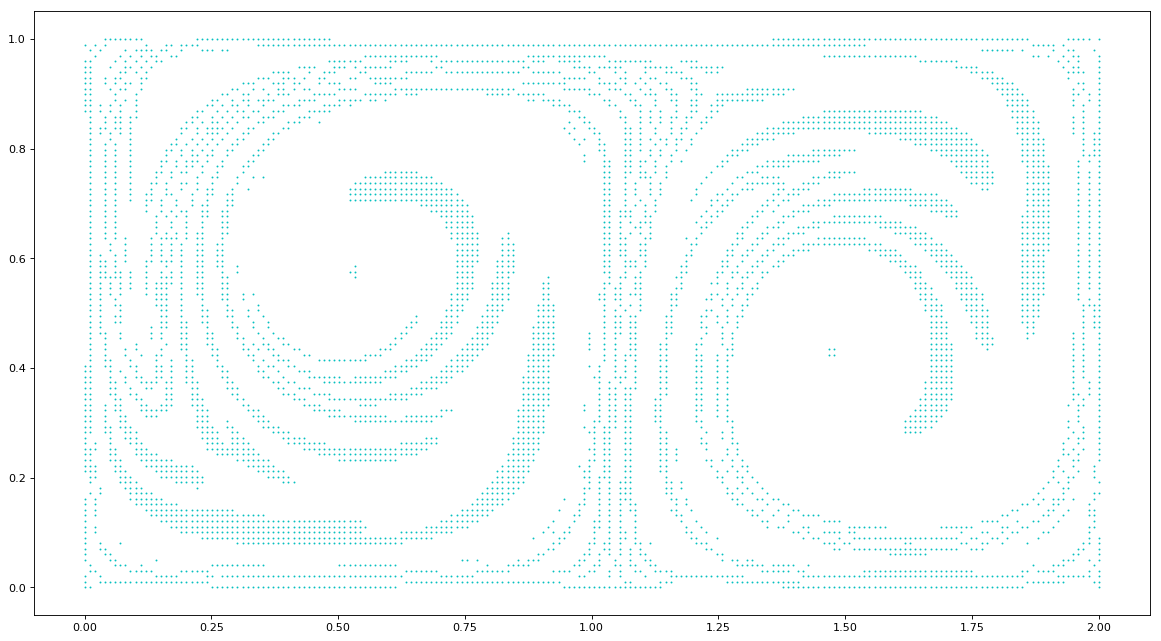

In [21]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=2, color='c')
#plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/0.old/20171003_ABfield/ABfield_max_method=%s_t=%i_ha=%f.png'
#            %(method,tend,ha),dpi=300)

plt.show()

In [22]:
# Functions for computing strainlines and identifying LCSs

#################### Making necessary interpolation objects ####################

def Eigen_itp(pos,lambda1,lambda2,eigvec1,eigvec2,order): #Interpolate for use in development of strainlines
    y0_pos, x0_pos = np.linspace(0,H,Ny), np.linspace(0,L,Nx)
    lambda1_2D, lambda2_2D, lapll_2D, eigvec1_2D, eigvec2_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)
    # Interpolate eigenvalues
    lmd1 = RBS(y0_pos,x0_pos, lambda1_2D, kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    lmd2 = RBS(y0_pos,x0_pos, lambda2_2D, kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    # Interpolate laplacian
    Laplacian = RBS(y0_pos,x0_pos, lapll_2D, kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    # Interpolate x and y components of the first eigenvector
    xi1y = RBS(y0_pos,x0_pos, eigvec1_2D[0,:,:], kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    xi1x = RBS(y0_pos,x0_pos, eigvec1_2D[1,:,:], kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    # Interpolate x and y components of the second eigenvector
    xi2y = RBS(y0_pos,x0_pos, eigvec2_2D[0,:,:], kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    xi2x = RBS(y0_pos,x0_pos, eigvec2_2D[1,:,:], kx = order, ky = order, bbox=[-pad_fac*H,(1+pad_fac)*H,-pad_fac*L,(1+pad_fac)*L])
    return lmd1, lmd2, Laplacian, xi1y, xi1x, xi2y, xi2x

def convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll):
    lambda1_2D, lambda2_2D, lapll_2d = np.zeros((Ny,Nx)), np.zeros((Ny,Nx)), np.zeros((Ny,Nx)) # Need to swap Ny and Nx?
    eigvec1_2D, eigvec2_2D = np.zeros((2,Ny,Nx)), np.zeros((2,Ny,Nx))
    for i in range(0,Ny):
        lambda1_2D[i,0:Nx] = lambda1[i*Nx:Nx*(i+1)]
        lambda2_2D[i,0:Nx] = lambda2[i*Nx:Nx*(i+1)]
        lapll_2d[i,0:Nx] = lapll[i*Nx:Nx*(i+1)]
        eigvec1_2D[:,i,0:Nx] = eigvec1[:,i*Nx:Nx*(i+1)]
        eigvec2_2D[:,i,0:Nx] = eigvec2[:,i*Nx:Nx*(i+1)]
    return lambda1_2D, lambda2_2D, lapll_2d, eigvec1_2D, eigvec2_2D

#################### Selecting points in "AB domain" that are on top of lines ####################

def eval_point(domain_points_y, domain_points_x, Ly_index, Lx_index,i,j):
    if(np.round((domain_points_y[i])/deltay).astype(int) == Ly_index[j]):
        return True
    if(np.round((domain_points_x[i])/deltax).astype(int) == Lx_index[j]):
        for k in range(0,len(Ly_index)):
            if(np.round((domain_points_y[i])/deltay).astype(int) == Ly_index[k]):
                return False
        return True
    return False
                
def selectg0(domain_points_y,domain_points_x,Ly_index,Lx_index):
    domain_points_tmp = np.zeros((2,len(domain_points_y)))
    counter = 0
    for j in range(0,len(Ly_index)):
        for i in range(0,len(domain_points_y)):
            if(eval_point(domain_points_y, domain_points_x, Ly_index, Lx_index,i,j)):
                domain_points_tmp[0,counter], domain_points_tmp[1, counter] = domain_points_y[i], domain_points_x[i]
                counter = counter + 1
    domain_points = domain_points_tmp[:,0:counter]
    return domain_points[0,:], domain_points[1,:]
    
######################################### Iterating single strainlines #########################################

def iteratestrainline(y_lst,x_lst,d,tol,lf): # Develop a single strainline by integration
    lfail, counter, linelength, stopcriterion = 0, 0, 0, np.zeros((4,1)) #Edge, stationary, outside AB, itmax
    coords, newcoord = np.zeros((2,1)), np.zeros((2,1))
    coords[0,0], coords[1,0] = y_lst, x_lst
    xi1 = xi1value_localinterp(y_lst,x_lst, np.zeros((2,1)))
    xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0])
    r_lst = xi1
    #newcoord[0,0], newcoord[1,0] = coords[0,-1] + d*r_lst[0,0], coords[1,-1] + d*r_lst[1,0]
    #newcoord = RK2iterator(y_lst,x_lst, r_lst, d)
    newcoord = RK4iterator(y_lst,x_lst, r_lst, d)
    while(lfail<lf and computealpha(lmd1,lmd2,newcoord[0,0],newcoord[1,0])>10**(-tol) and inDomain(newcoord[0,0],newcoord[1,0]) and counter < itmax): 
        coords = np.append(coords, newcoord,1)
        #newcoord[0,0], newcoord[1,0] = coords[0,-1] + d*r_lst[0,0], coords[1,-1] + d*r_lst[1,0]
        #newcoord = RK2iterator(newcoord[0,0],newcoord[1,0], r_lst, d)
        newcoord = RK4iterator(newcoord[0,0],newcoord[1,0], r_lst, d)
        r_lst = xi1value_localinterp(newcoord[0,0],newcoord[1,0], r_lst)
        if (not inAB(newcoord[0,0],newcoord[1,0])):
            lfail = lfail + np.sqrt((newcoord[0,0]-coords[0,-1])**2+(newcoord[1,0]-coords[1,-1])**2)
        else:
            lfail = 0
        linelength = linelength + np.sqrt((newcoord[0,0]-coords[0,-1])**2+(newcoord[1,0]-coords[1,-1])**2)
        counter = counter+1
    l2_avg = np.average(lmd2.ev(coords[0,1:],coords[1,1:])) # NOTE: Ignoring first point since treated in reverse it
    if(not inDomain(newcoord[0,0],newcoord[1,0])):
        stopcriterion[0,0] = 1
    if(computealpha(lmd1,lmd2,newcoord[0,0],newcoord[1,0])<=10**(-tol)):
        stopcriterion[1,0] = 1
    if(lfail > lf):
        stopcriterion[2,0] = 1
    if(counter >= itmax):
        stopcriterion[3,0] = 1
    return coords, l2_avg, linelength, stopcriterion

def iteratestrainline_reverse(y_lst,x_lst,d,tol,lf): # Develop a single strainline by integration
    lfail, counter, linelength, stopcriterion = 0, 0, 0, np.zeros((4,1))
    r_lst, coords, newcoord, xi1 = np.ones((2,1)), np.zeros((2,1)), np.zeros((2,1)), np.zeros((2,1))
    coords[0,0], coords[1,0] = y_lst, x_lst
    xi1 = xi1value_localinterp(y_lst,x_lst, np.zeros((2,1)))
    xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0])
    r_lst = -xi1
    #newcoord[0,0], newcoord[1,0] = coords[0,-1] + d*r_lst[0,0], coords[1,-1] + D*r_lst[1,0]
    #newcoord = RK2iterator(y_lst,x_lst, r_lst, d)
    newcoord = RK4iterator(y_lst,x_lst, r_lst, d)
    while(lfail<=lf and computealpha(lmd1,lmd2,newcoord[0,0],newcoord[1,0])>10**(-tol) and inDomain(newcoord[0,0],newcoord[1,0]) and counter < itmax): 
        coords = np.append(coords, newcoord,1)
        #newcoord[0,0], newcoord[1,0] = coords[0,-1] + d*r_lst[0,0], coords[1,-1] + d*r_lst[1,0]
        #newcoord = RK2iterator(newcoord[0,0],newcoord[1,0], r_lst, d)
        newcoord = RK4iterator(newcoord[0,0],newcoord[1,0], r_lst, d)
        r_lst = xi1value_localinterp(newcoord[0,0],newcoord[1,0], r_lst)
        if (not inAB(newcoord[0,0],newcoord[1,0])):
            lfail = lfail + np.sqrt((newcoord[0,0]-coords[0,-1])**2+(newcoord[1,0]-coords[1,-1])**2)
        else:
            lfail = 0
        linelength = linelength + np.sqrt((newcoord[0,0]-coords[0,-1])**2+(newcoord[1,0]-coords[1,-1])**2)
        counter = counter+1
    l2_avg = np.average(lmd2.ev(coords[0,:],coords[1,:]))
    if(not inDomain(newcoord[0,0],newcoord[1,0])):
        stopcriterion[0,0] = 1
    if(computealpha(lmd1,lmd2,newcoord[0,0],newcoord[1,0])<=10**(-tol)):
        stopcriterion[1,0] = 1
    if(lfail > lf):
        stopcriterion[2,0] = 1
    if(counter >= itmax):
        stopcriterion[3,0] = 1
    return coords, l2_avg, linelength, stopcriterion

#def computedrds(y,x,drds_lst): # Compute the gradient of the strainline
#    xi1, drds = np.zeros((2,1)), np.zeros((2,1))
#    xi1 = xi1value(y,x) #xi1[0,0], xi1[1,0] = xi1y.ev(y,x), xi1x.ev(y,x)
#    xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0])
#    drds = np.sign(np.dot(np.transpose(xi1),drds_lst))*xi1 #*computealpha(lmd1,lmd2,y,x)
#    return drds

#def computedrds_reverse(y,x,drds_lst): # Compute the gradient of the strainline
#    xi1, drds = np.zeros((2,1)), np.zeros((2,1))
#    xi1 = xi1value(y,x) #xi1[0,0], xi1[1,0] = -xi1y.ev(y,x), -xi1x.ev(y,x)
#    xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0]) #xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0])
#    xi1 = -xi1
#    drds = np.sign(np.dot(np.transpose(xi1),drds_lst))*xi1 #*computealpha(lmd1,lmd2,y,x)
#    return drds

def computealpha(lmd1,lmd2,y,x): #Compute alpha for use in the gradient of the strainline
    alpha = ((lmd2.ev(y,x) - lmd1.ev(y,x))/(lmd2.ev(y,x) + lmd1.ev(y,x)))**2
    return alpha

def inAB(y_lst, x_lst): #Check whether a point satisfies conditions A and B
    xi2 = np.zeros(2)
    xi2[0], xi2[1] = normalize(xi2y.ev(y_lst,x_lst), xi2x.ev(y_lst,x_lst))
    return (max(lmd1.ev(y_lst,x_lst),lmd2.ev(y_lst,x_lst)) > 1 and (lmd2.ev(y_lst,x_lst)-lmd1.ev(y_lst,x_lst)) != 0 and np.dot(xi2,Laplacian.ev(y_lst,x_lst)*xi2) <= 0)

def inDomain(y_lst,x_lst):
    return (y_lst >= 0-pad_fac*H and y_lst <= H+pad_fac*H and x_lst >= 0-pad_fac*L and x_lst <= L+pad_fac*L)

################################## Linear interpolation like in "LCS tool" #############################################
#@jit(nopython=True)
#def findclosestgridpoints(y,x):
#    y_loind, x_loind = max(0,min(np.floor(y/deltay),Ny-1)), max(0,min(np.floor(x/deltax),Nx-1))
#    y_hiind, x_hiind = min(y_loind + 1, Ny-1), min(x_loind + 1, Nx-1)
#    return int(y_loind), int(y_hiind), int(x_loind), int(x_hiind)

#def xi1value(y,x): #,last
#    y_lo, y_hi, x_lo, x_hi = findclosestgridpoints(y,x)
#    xi1_ll, xi1_lr, xi1_ul, xi1_ur = np.zeros((2,1)), np.zeros((2,1)), np.zeros((2,1)), np.zeros((2,1))
#    xi1_ll[0:2,0] = eigvec1_2D[:,y_lo,x_lo]
#    xi1_lr[0:2,0] = eigvec1_2D[:,y_lo,x_hi]
#    xi1_ul[0:2,0] = eigvec1_2D[:,y_hi,x_lo]
#    xi1_ur[0:2,0] = eigvec1_2D[:,y_hi,x_hi]
#    xi1_ll, xi1_lr, xi1_ul, xi1_ur = correct_dir(xi1_ll, xi1_lr, xi1_ul, xi1_ur)
#    xi1 = bilinear_interp(y, x, xi1_ll, xi1_lr, xi1_ul, xi1_ur, y_lo, y_hi, x_lo, x_hi)
#    return xi1
    #if(np.dot(np.transpose(last),xi1) >= 0):
    #    return xi1
    #else:
    #    xi1[0:2,0] = -xi1[0:2,0]
    #    return xi1

def xi1value_localinterp(y,x,last):
    if(y > H):
        y = H
    if(y < 0):
        y = 0
    if(x > L):
        x = L
    if(x < 0):
        x = 0
    y_lo, x_lo = int(max(0,min(np.floor(y/deltay),Ny-1))), int(max(0,min(np.floor(x/deltax),Nx-1)))
    y_hi, x_hi = min(y_lo + 1, Ny-1), min(x_lo + 1, Nx-1)
    localxi = np.zeros((2,2,2))
    localxi[:,0:y_hi+1-y_lo,0:x_hi+1-x_lo] = eigvec1_2D[:,y_lo:y_hi+1,x_lo:x_hi+1]
    
    # Adjust any vectors opposing the others
    for j in range(0,y_hi+1-y_lo):
        for i in range(0,x_hi+1-x_lo):
            if(i==0 and j==0):
                pass
            else:
                dotproduct = np.dot(localxi[::-1,0,0],localxi[::-1,j,i])
                if(dotproduct < 0):
                    localxi[:,j,i] = -localxi[:,j,i]
    wy_right, wx_top = (y-y_lo*deltay)/deltay, (x-x_lo*deltax)/deltax
    wy_left, wx_bot = 1 - wy_right, 1 - wx_top
    xi_itp = wy_left*(wx_bot*localxi[:,0,0]+wx_top*localxi[:,0,1])+wy_right*(wx_bot*localxi[:,1,0]+wx_top*localxi[:,1,1]) 
    xi_itp = xi_itp.reshape(2,1)
    if (np.dot(np.transpose(xi_itp),last) < 0):
        return -xi_itp
    return xi_itp

def computedrds(y,x,drds_lst):
    xi1 = xi1value_localinterp(y,x,drds_lst)
    #if(np.sqrt(xi1[0,0]**2 + xi1[1,0]**2) > 10**(-15)):
    xi1[0,0], xi1[1,0] = normalize(xi1[0,0], xi1[1,0])
    return xi1

def normalize(xiy,xix):
    modulus = np.sqrt(xiy**2 + xix**2)
    return xiy/modulus, xix/modulus
    
#def bilinear_interp(y, x, xi1_ll, xi1_lr, xi1_ul, xi1_ur, y_lo, y_hi, x_lo, x_hi):
#    lowVal, higVal = np.zeros((2,1)), np.zeros((2,1))
#    lowVal[0:2,0] = np.average(np.concatenate((xi1_ll,xi1_lr),axis=1),axis=1, weights=[abs(x-x_lo)/deltax, abs(x_hi-x)/deltax])
#    higVal[0:2,0] = np.average(np.concatenate((xi1_ul,xi1_ur),axis=1),axis=1, weights=[abs(x-x_lo)/deltax, abs(x_hi-x)/deltax])
#    xi1 = np.zeros((2,1))
#    xi1[0:2,0] = np.average(np.concatenate((lowVal,higVal),axis=1),axis=1,weights=[abs(y-y_lo)/deltay,abs(y_hi-y)/deltay])
#    return xi1 

#def correct_dir(vec1, vec2, vec3, vec4): #Using lower left as a reference instead of the average of the remaining vectors
#    if(np.dot(vec1.T,vec2)<0):
#        vec2[0:2,0] = -vec2[0:2,0]
#    if(np.dot(vec1.T,vec3)<0):
#        vec3[0:2,0] = -vec3[0:2,0]
#    if(np.dot(vec1.T,vec4)<0):
#        vec4[0:2,0] = -vec4[0:2,0]   
#    return vec1, vec2, vec3, vec4

##################################### Intergration scheme implementation ############################################

def RK4iterator(y_lst,x_lst, drds_lst, d):
    newcoord = np.zeros((2,1))
    lk = np.zeros((2,5))
    lk[:,1:2] = computedrds(y_lst,x_lst,drds_lst)
    lk[:,2:3] = computedrds(y_lst + lk[0,1]*d/2, x_lst + lk[1,1]*d/2, drds_lst)
    lk[:,3:4] = computedrds(y_lst + lk[0,2]*d/2, x_lst + lk[1,2]*d/2, drds_lst)
    lk[:,4:5] = computedrds(y_lst + lk[0,3]*d, x_lst + lk[1,3]*d, drds_lst)
    lk[:,0:1] = (lk[:,1:2] + 2*lk[:,2:3] + 2*lk[:,3:4] + lk[:,4:5])/6
    newcoord[0,0] = y_lst + d*lk[0,0]
    newcoord[1,0] = x_lst + d*lk[1,0]
    return newcoord

#Heun's method
def RK2iterator(y_lst,x_lst, drds_lst, d):
    newcoord = np.zeros((2,1))
    lk = np.zeros((2,2))
    lk[:,0:1] = computedrds(y_lst,x_lst,drds_lst)
    lk[:,1:2] = computedrds(y_lst + lk[0,0]*d, x_lst + lk[1,0]*d, drds_lst)
    newcoord[0,0] = y_lst + (lk[0,0]+lk[0,1])*d/2
    newcoord[1,0] = x_lst + (lk[1,0]+lk[1,1])*d/2
    return newcoord

############################### Iterate all strainlines by calling iteratestrainline #################################
    
def computestrainlines(domain_points_y,domain_points_x,d,tol,lf,lmin,Pnum,q):
    # Compute the strainlines as arrays of x and y coordinates, as well as domains and average lambda2 value
    domain_points_y, domain_points_x = selectg0(domain_points_y,domain_points_x,Ly_index,Lx_index)
    strainlines = []
    l2_averages = []
    linelengths = []
    stopcriteria = np.zeros((8,1))
    for i in range(0,np.size(domain_points_y)):
        strainline_1, l2_avg_1, linelength_1, stopcriterion_1 = iteratestrainline(domain_points_y[i],domain_points_x[i],d,tol,lf)
        strainline_2, l2_avg_2, linelength_2, stopcriterion_2 = iteratestrainline_reverse(domain_points_y[i],domain_points_x[i],d,tol,lf)
        strainline = np.append(strainline_2[:,::-1], strainline_1[:,1:],1)
        l2_avg = (l2_avg_1*(len(strainline_1)-1) + l2_avg_2*len(strainline_2))/len(strainline)
        linelength = linelength_1 + linelength_2
        stopcriterion = np.append(stopcriterion_1, stopcriterion_2, 0)
        strainlines.append(strainline)
        l2_averages.append(l2_avg)
        linelengths.append(linelength)
        stopcriteria = np.append(stopcriteria,stopcriterion,1)
        if((not np.mod(i,100)) and (i!=0)):
            print('%i of %i strainlines computed in process %i' %(i,np.size(domain_points_y),Pnum))
    stopcriteria = stopcriteria[:,1:]
    q.put(strainlines)
    q.put(l2_averages)
    q.put(linelengths)
    q.put(stopcriteria)
    #return strainlines, l2_averages
    
#################### Finding intersections with lines and recording the corresponding coordinates ####################

def findintersections(strainlines,l2_averages):
    # Find where each strainline crosses lines
    Nstrainlines = len(l2_averages)
    intersections_htal = np.zeros((len(Ly),Nstrainlines,max_intsec_guess))
    intersections_vert = np.zeros((len(Ly),Nstrainlines,max_intsec_guess))
    counter_htal = np.zeros((len(Ly),Nstrainlines))
    counter_vert = np.zeros((len(Ly),Nstrainlines))
    for i in range(0,Nstrainlines):
        for j in range(0,len(Ly)):
            for k in range(0,np.size(strainlines[i][0,:])-1):
                if((strainlines[i][0,k] < Ly[j] and strainlines[i][0,k+1] > Ly[j]) or (strainlines[i][0,k] > Ly[j] and strainlines[i][0,k+1] < Ly[j])):
                    intersections_htal[j,i,int(counter_htal[j,i])] = (strainlines[i][1,k] + strainlines[i][1,k+1])/2
                    counter_htal[j,i] = counter_htal[j,i] + 1
                    if(counter_htal[j,i] > max_intsec_guess-1):
                        intersections_htal = np.append(intersections_htal,np.zeros((len(Ly),Nstrainlines,1)),2)
            for k in range(0,np.size(strainlines[i][0,:])-1):
                if((strainlines[i][1,k] < Lx[j] and strainlines[i][1,k+1] > Lx[j]) or (strainlines[i][1,k] > Lx[j] and strainlines[i][1,k+1] < Lx[j])):
                    intersections_vert[j,i,int(counter_vert[j,i])] = (strainlines[i][0,k] + strainlines[i][0,k+1])/2
                    counter_vert[j,i] = counter_vert[j,i] + 1
                    if(counter_vert[j,i] > max_intsec_guess-1):
                        intersections_vert = np.append(intersections_vert,np.zeros((len(Ly),Nstrainlines,1)),2)
    return intersections_htal, intersections_vert

def shapeconvert(intersections, maxintersections):
    intersections_new = np.zeros((intersections.shape[0], intersections.shape[1], maxintersections))
    intersections_new[:,:,0:intersections.shape[2]] = intersections
    return intersections_new

### Finding "near enough" neighbors to compare largest eigenvalue ###
           
# Make compatible with above function
def findneighbors(strainlines,l2_averages,intersections_htal,intersections_vert,n0,nend,Pnum,q):
    Nstrainlines = len(l2_averages)
    Nlines = len(Ly)
    # Find the neighbors along each of the lines which the strainlines cross
    allneighbors = []
    maxintersections = max(intersections_htal.shape[2],intersections_vert.shape[2])
    if(intersections_htal.shape[2] < maxintersections):
        intersections_htal = shapeconvert(intersections_htal, maxintersections)
    elif(intersections_vert.shape[2] < maxintersections):
        intersections_vert = shapeconvert(intersections_vert, maxintersections)
    intersections = np.append(intersections_htal,intersections_vert,0)
    for i in range(n0,nend):
        neighbors = []
        for j in range(0,Nlines*2):
            lineneighbors = []
            lineneighbors.append(i)
            for k in range(0,Nstrainlines):
                # Need to iterate through all the different intersections (one more for loop)
                for m in range(0,maxintersections):
                    if(k!=i and min(intersections[j,i,m],intersections[j,k,m]) > 0 and abs(intersections[j,i,m]-intersections[j,k,m]) < Ln):
                        lineneighbors.append(k)
            neighbors.append(lineneighbors)
        allneighbors.append(neighbors)
        if((not np.mod(i-n0,100)) and (i-n0!=0)):
            print('Neighbors for %i of %i strainlines computed in process %i' %(i-n0,nend-n0,Pnum))
    q.put(allneighbors)
    #return allneighbors

#################### Selecting LCS from strainlines + converting to plottable format ####################

def findLCS(strainlines,allneighbors,l2_averages, linelengths): # Select strainlines that have largest l2 in at least one neighborhood
    Nlines = len(Ly)
    LCS = []
    for i in range(0,len(l2_averages)):
        for j in range(0,Nlines*2):
            indexes = np.asarray(allneighbors[i][j])
            T = [l2_averages[k] for k in indexes]
            if(l2_averages[i] >= max(T) and len(T) > 1 and linelengths[i] > lmin):
                LCS.append(strainlines[i])
                print('Strainline %i is an LCS!' %i)
                break
    print(len(LCS))
    return LCS

def converttoarray(LCS):
    Npoints = 0
    index = 0
    for i in range(0,len(LCS)):
        Npoints = Npoints + LCS[i].shape[1]
    LCS_array = np.zeros((2,Npoints))
    for i in range(0,len(LCS)):
        length = LCS[i].shape[1]
        LCS_array[:,index:index+length] = LCS[i]
        index = index + length
    return LCS_array

In [23]:
# Setting parameters
codeit = 13 # REMEMBER TO CHANGE FOR EACH CODE ITERATION
itmethod = 'RK4' # REMEMBER TO KEEP UP TO DATE
d, lf, Ln, lmin = 0.0005, 0.2, 0.2, 1
odr = 1
tol = 6
itmax = 10000
pad_fac = 0.01
dL = 0.2 # Distance between horizontal and vertical lines
Ly, Lx = np.linspace(dL, H-dL, int(H/(dL))-1), np.linspace(2*dL, L-2*dL, int(L/(2*dL))-1)
Ly_index, Lx_index = np.ceil(np.linspace(Ny/5,Ny*(4/5),4)).astype(int), np.ceil(np.linspace(Nx/5,Nx*(4/5),4)).astype(int)
max_intsec_guess = 10
             
# Functions for computing strainlines and identifying LCSs
start, tic = time.time(), time.time()
lmd1, lmd2, Laplacian, xi1y, xi1x, xi2y, xi2x = Eigen_itp(pos_a,lambda1,lambda2,eigvec1,eigvec2,odr)
eigvec1_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)[3]
print('Finishing interpolation and conversion to 2D')

div = np.floor([np.linspace(0,len(domain_points_y),Ncores+1)])
div = div.astype(int)
q, p, strainlines, l2_averages, linelengths, stopcriteria = [], [], [], [], [], np.zeros((8,1))
print('Starting iteration')

for i in range(0, Ncores):
    q.append(mp.Queue())
    p.append(mp.Process(target=computestrainlines, args=(domain_points_y[div[0,i]:div[0,i+1]],domain_points_x[div[0,i]:div[0,i+1]],d,tol,lf,lmin,i,q[i])))
for i in range(0, Ncores):
    p[i].start()
for i in range(0, Ncores):
    strainlines_section, l2_averages_section, linelengths_section, stopcriteria_section = q[i].get(), q[i].get(), q[i].get(), q[i].get()
    strainlines = strainlines + strainlines_section
    l2_averages = l2_averages + l2_averages_section
    linelengths = linelengths + linelengths_section
    stopcriteria = np.append(stopcriteria, stopcriteria_section, 1)
for i in range(0, Ncores):
    p[i].join()
    
stopcriteria = stopcriteria[:,1:] # Discarding first empty element

print('Iteration time: %i minutes, %f seconds' %(divmod(time.time()-start, 60)))
print('Number of strainlines = %i' %len(strainlines))

Finishing interpolation and conversion to 2D
Starting iteration
Iteration time: 6 minutes, 56.624005 seconds
Number of strainlines = 299


In [24]:
start = time.time()

intersections_htal, intersections_vert = findintersections(strainlines, l2_averages)
print('Intersections identified in %i minutes and %f seconds' %(divmod(time.time()-start, 60)))
start = time.time()

div = np.floor([np.linspace(0,len(l2_averages),Ncores+1)])
div = div.astype(int)
q, p, allneighbors = [], [], []

for i in range(0, Ncores):
    q.append(mp.Queue())
    p.append(mp.Process(target=findneighbors, args=(strainlines,l2_averages,intersections_htal,intersections_vert,div[0,i],div[0,i+1],i,q[i])))
for i in range(0, Ncores):
    p[i].start()
for i in range(0, Ncores):
    allneighbors_section = q[i].get()
    allneighbors = allneighbors + allneighbors_section
for i in range(0, Ncores):
    p[i].join()

print('Neighbors identified in %i minutes and %f seconds' %(divmod(time.time()-start, 60)))
start = time.time()
LCS = findLCS(strainlines,allneighbors,l2_averages, linelengths)
minutes, seconds = divmod(time.time()-start, 60)
print('%i Lagrangian coherent structures identified in %i minutes and %f seconds' %(len(LCS), minutes, seconds)) 
LCS_array = converttoarray(LCS)
print('Total time spent: %i minutes, %f seconds' %(divmod(time.time()-tic, 60)))

Intersections identified in 0 minutes and 15.575024 seconds
Neighbors identified in 0 minutes and 4.453229 seconds
Strainline 34 is an LCS!
Strainline 63 is an LCS!
Strainline 109 is an LCS!
Strainline 254 is an LCS!
Strainline 258 is an LCS!
Strainline 290 is an LCS!
6
6 Lagrangian coherent structures identified in 0 minutes and 0.045458 seconds
Total time spent: 7 minutes, 16.773646 seconds


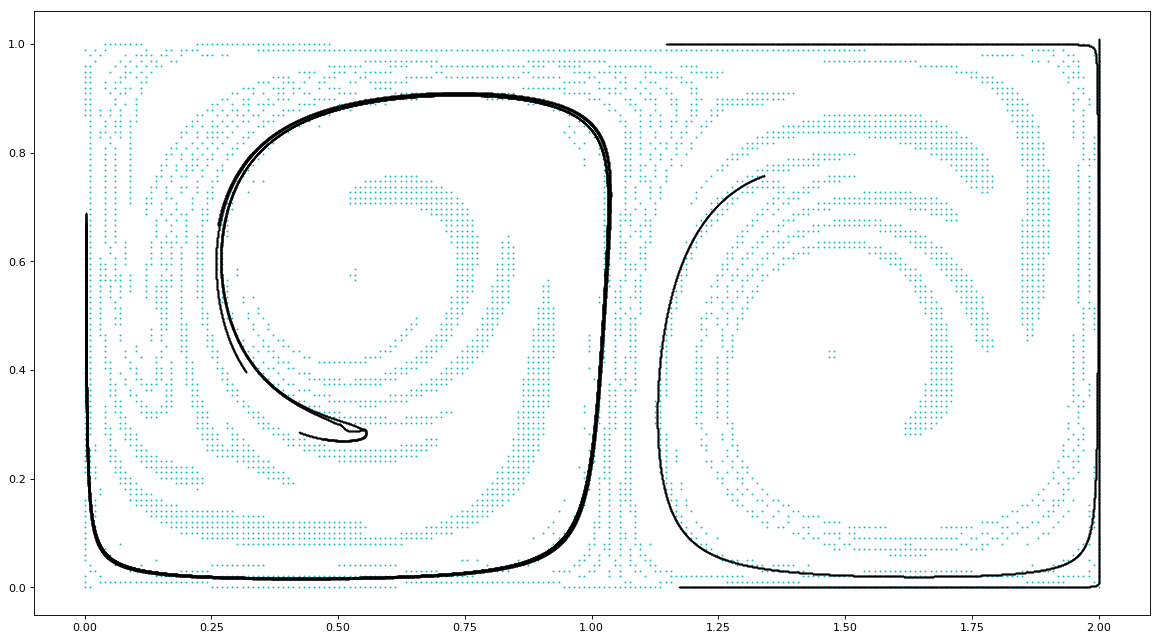

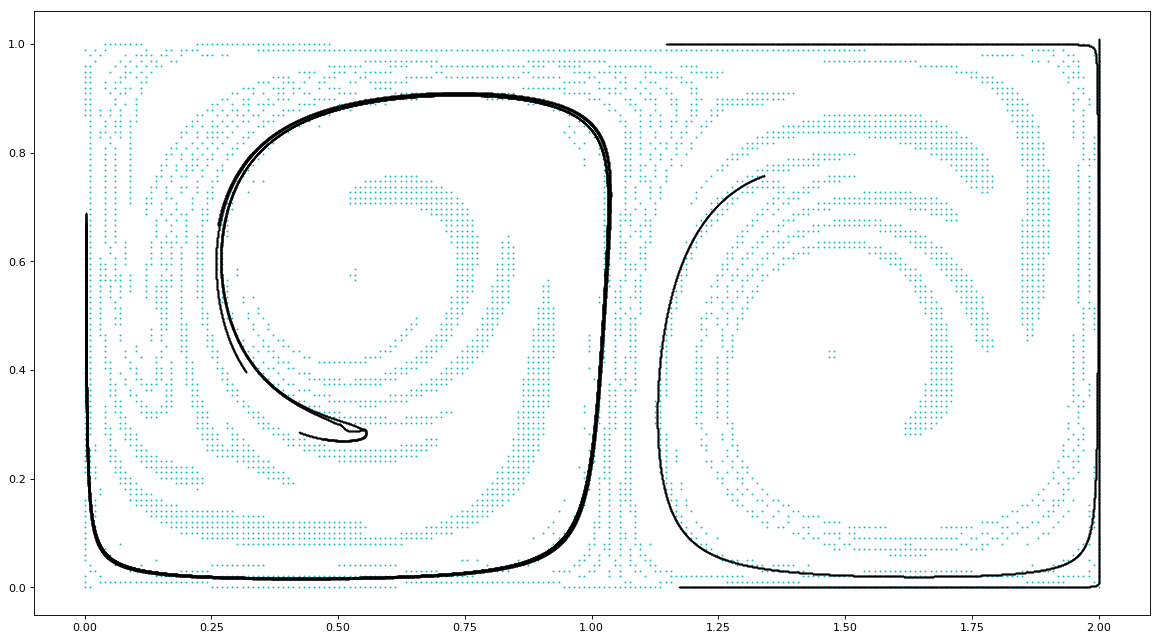

In [26]:
# Plotting the results
#g0y, g0x = selectg0(domain_points_y,domain_points_x,Ly_index,Lx_index)
#plt.scatter(g0x, g0y, marker='.', s=2, color='r')
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=2, color='c')
plt.scatter(LCS_array[1,:],LCS_array[0,:], marker='.', s=0.5, color='k')
#plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/DG-LCSplots/%s_iteration=%i_itmethod=%s_t=%i_ha=%f_itmax=%i_d=%f_lf=%f_lmin=%f_Ln=%f.png' 
#            %(time.strftime("%Y%m%d"),codeit,itmethod,tend,ha,itmax,d,lf,lmin,Ln))
plt.show()

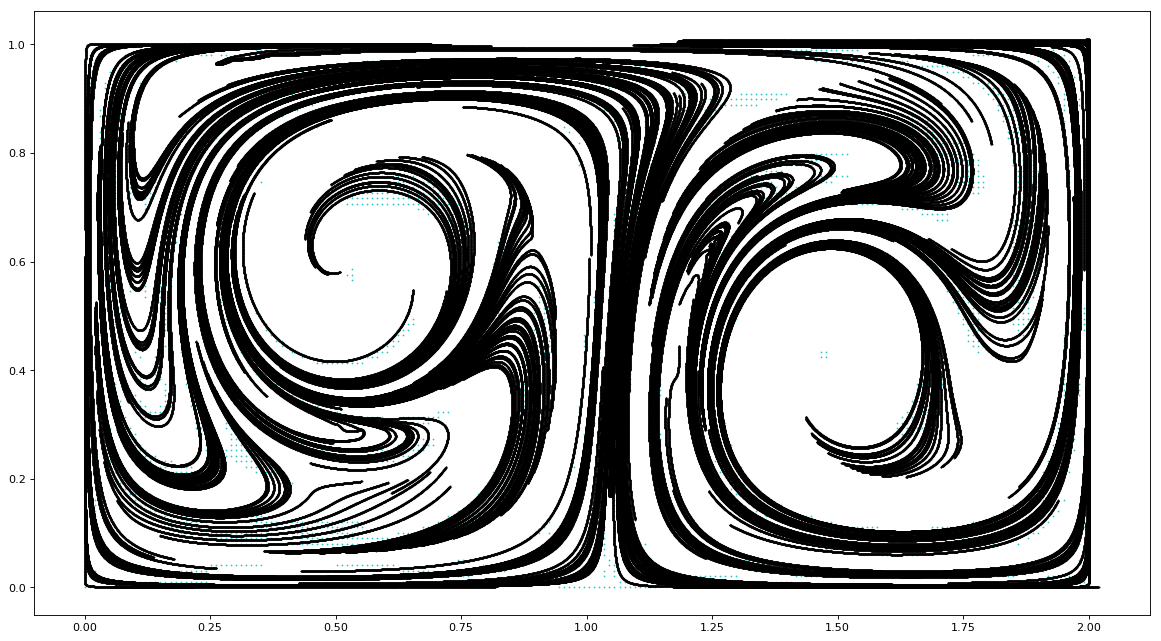

In [27]:
# Plotting the strainlines                  
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=1, color='c')
for i in range(0,len(strainlines)):
    plt.scatter(strainlines[i][1,:],strainlines[i][0,:], marker='.', s=2, color='k')
#plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/DG-strainlineplots/%s_iteration=%i_itmethod=%s_t=%i_ha=%f_itmax=%i_d=%f_lf=%f_lmin=%f_Ln=%f.png' 
#            %(time.strftime("%Y%m%d"),codeit,itmethod,tend,ha,itmax,d,lf,lmin,Ln))
plt.show()

In [ ]:
# Plotting the results
#fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
#plt.scatter(domain_points_x,domain_points_y, marker='.', s=2, color='c')
#strainline_num = [168, 247, 359, 377, 378, 696]
#
#for i in range(0,6):
#    plt.scatter(LCS[i][1,:],LCS[i][0,:], marker='.', s=0.5, color='k')
#for i in range(0,6):
#    plt.scatter(strainlines[strainline_num[i]][1,:],strainlines[strainline_num[i]][0,:], marker='.', s=0.5, color='k')
#plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/DG-LCSplots/%s_iteration=%i_itmethod=%s_t=%i_ha=%f_itmax=%i_d=%f_lf=%f_lmin=%f_Ln=%f.png' 
#            %(time.strftime("%Y%m%d"),codeit,itmethod,tend,ha,itmax,d,lf,lmin,Ln))
#plt.show()

296
296


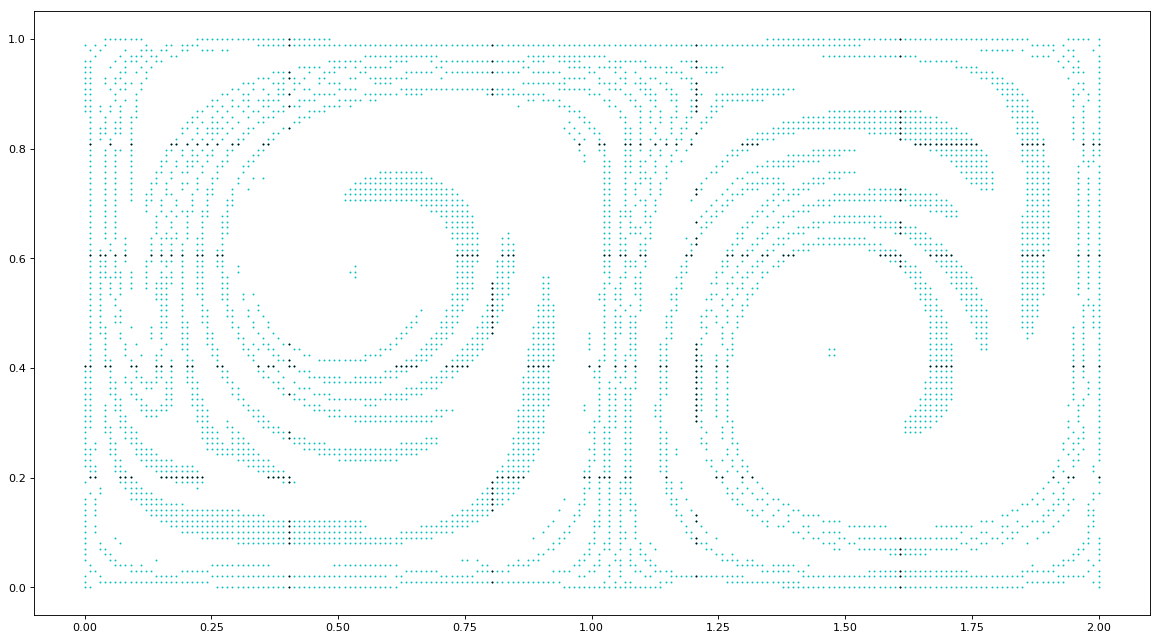

In [23]:
# Plotting the initial positions of the data set
g0y, g0x = selectg0(domain_points_y,domain_points_x,Ly_index,Lx_index)

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=2, color='c')
plt.scatter(g0x, g0y, marker='.', s=2, color='k')

print(len(g0x))
print(len(g0y))
#print(Ly_index*deltay)
#print(Lx_index*deltax)
#print(deltax)
#print(deltay)

plt.show()

In [126]:
print(strainlines[strainlinenum][:,2873:2875])
print(xi1y(0.85027786, 0.41172121))
print(xi1x(0.85027786, 0.41172121))
print(xi2y(0.85027786, 0.41172121))
print(xi2x(0.85027786, 0.41172121))
print(lmd1(0.85027786, 0.41172121))
print(lmd2(0.85027786, 0.41172121))
print('----------------------------')
print(xi1y(0.72727701, 0.16473765))
print(xi1x(0.72727701, 0.16473765))
print(xi2y(0.72727701, 0.16473765))
print(xi2x(0.72727701, 0.16473765))
print(lmd1(0.72727701, 0.16473765))
print(lmd2(0.72727701, 0.16473765))
print('----------------------------')
print(computealpha(lmd1,lmd2,0.85027786, 0.41172121))
print(computealpha(lmd1,lmd2,0.72727701, 0.16473765))
print()

# Two alternatives: 

[[ 0.85027786  0.72727701]
 [ 0.41172121  0.16473765]]
[[-0.44352411]]
[[-0.8962628]]
[[ 0.8962628]]
[[-0.44352411]]
[[ 22.00209529]]
[[ 4782.05993843]]
----------------------------
[[-0.9404315]]
[[-0.33998322]]
[[ 0.33998322]]
[[-0.9404315]]
[[-0.00161994]]
[[ 2636.22189592]]
----------------------------
[[ 0.98176433]]
[[ 1.00000246]]


[ 1.  0.  0.  0.  0.  0.  1.  0.]


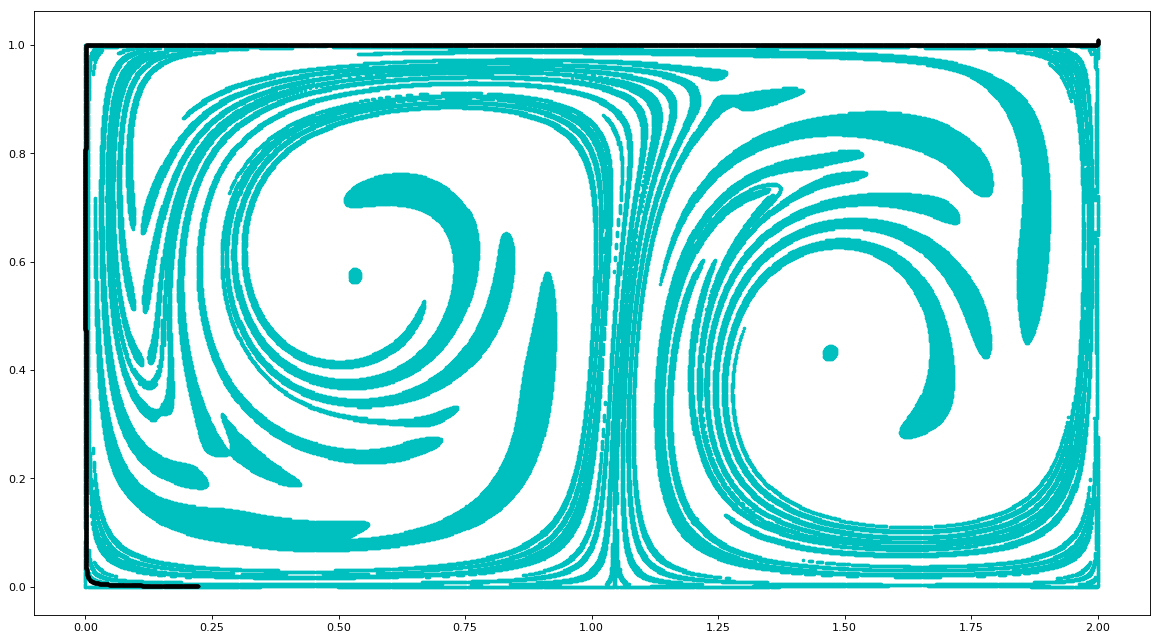

(6425,)


array([ 0.22268046,  0.22218046,  0.22168046,  0.22118047,  0.22068047,
        0.22018047,  0.21968048,  0.21918048,  0.21868048,  0.21818049])

In [29]:
# Plotting individual strainlines
strainlinenum = 1364
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=20, color='c')

plt.scatter(strainlines[strainlinenum][1,:],strainlines[strainlinenum][0,:], marker='.', s=20, color='k')
#plt.xlim(0,0.2)
#plt.ylim(0.3,0.5)

print(stopcriteria[:,strainlinenum])
#plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/Turningstrainline')
plt.show()
#Edge, stationary, outside AB, maxiterations
#Strainline 167 is an LCS!
#Strainline 200 is an LCS!
#Strainline 352 is an LCS!
#Strainline 687 is an LCS!
#Strainline 1003 is an LCS!
#Strainline 1020 is an LCS!
#Strainline 1364 is an LCS!
print(strainlines[strainlinenum][1,:].shape)
strainlines[strainlinenum][1,0:10]

In [31]:
print(strainlines[strainlinenum][:,6000:6010].T)

[[ 0.02013004  0.43000993]
 [ 0.02013004  0.43100993]
 [ 0.02013004  0.43000993]
 [ 0.02013004  0.43100993]
 [ 0.02013004  0.43000993]
 [ 0.02013004  0.43100993]
 [ 0.02013004  0.43000993]
 [ 0.02013004  0.43100993]
 [ 0.02013004  0.43000993]
 [ 0.02013004  0.43100993]]


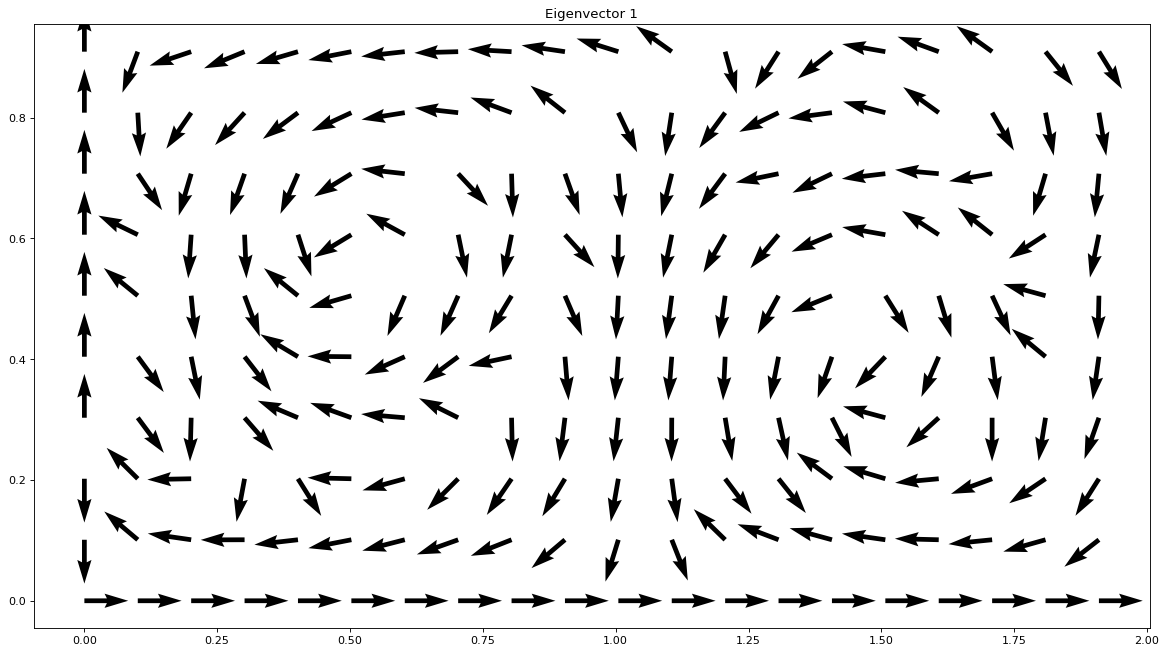

In [23]:
y0_pos, x0_pos = np.linspace(0,H,Ny), np.linspace(0,L,Nx)
y0_pos, x0_pos = y0_pos, x0_pos
y0_pos, x0_pos = y0_pos[::disp_freq], x0_pos[::disp_freq]
eigvec12D = eigvec1_2D[:,120:180,270:320]

Y, X = np.meshgrid(y0_pos, x0_pos)

plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Eigenvector 1')
plt.quiver(X, Y, eigvec1_2D[1,::disp_freq,::disp_freq].T, eigvec1_2D[0,::disp_freq,::disp_freq].T, units='width')
plt.show()

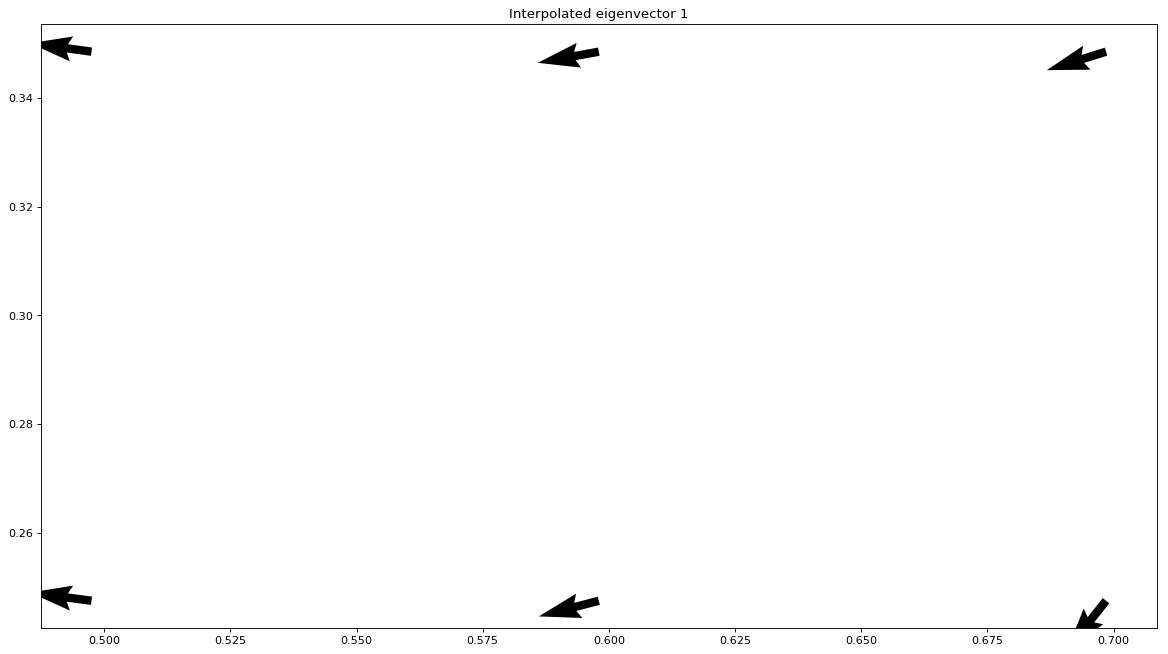

In [22]:
disp_freq = 10

eigvec2_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)[4]
eigvec1_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)[3]

# Interpolated

y0_pos, x0_pos = np.linspace(-deltay/2,H-deltay/2,Ny), np.linspace(-deltax/2,L-deltax/2,Nx)
#y0_pos, x0_pos = np.linspace(deltay/2,H-deltay/2,Ny-1), np.linspace(deltax/2,L-deltax/2,Nx-1)
y0_pos, x0_pos = y0_pos[int(Ny/4):int(3*Ny/8)], x0_pos[int(Nx/4):int(3*Nx/8)]
y0_pos, x0_pos = y0_pos[::disp_freq], x0_pos[::disp_freq]
Y, X = np.meshgrid(y0_pos, x0_pos)

eigvec1_2Dinterp = np.zeros((2,len(x0_pos),len(y0_pos)))
eigvec2_2Dinterp = np.zeros((2,len(x0_pos),len(y0_pos)))
        
for j in range(0,len(y0_pos)):
    eigvec1_2Dinterp[0,:,j] = xi1y(y0_pos[j],x0_pos)
    eigvec1_2Dinterp[1,:,j] = xi1x(y0_pos[j],x0_pos)
    eigvec2_2Dinterp[0,:,j] = xi2y(y0_pos[j],x0_pos)
    eigvec2_2Dinterp[1,:,j] = xi2x(y0_pos[j],x0_pos)

plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Interpolated eigenvector 1')
plt.quiver(X, Y, eigvec1_2Dinterp[1], eigvec1_2Dinterp[0], units='dots')
#plt.xlim(0.66,0.68)
#plt.ylim(0.27,0.32)

plt.show()

[[ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]]


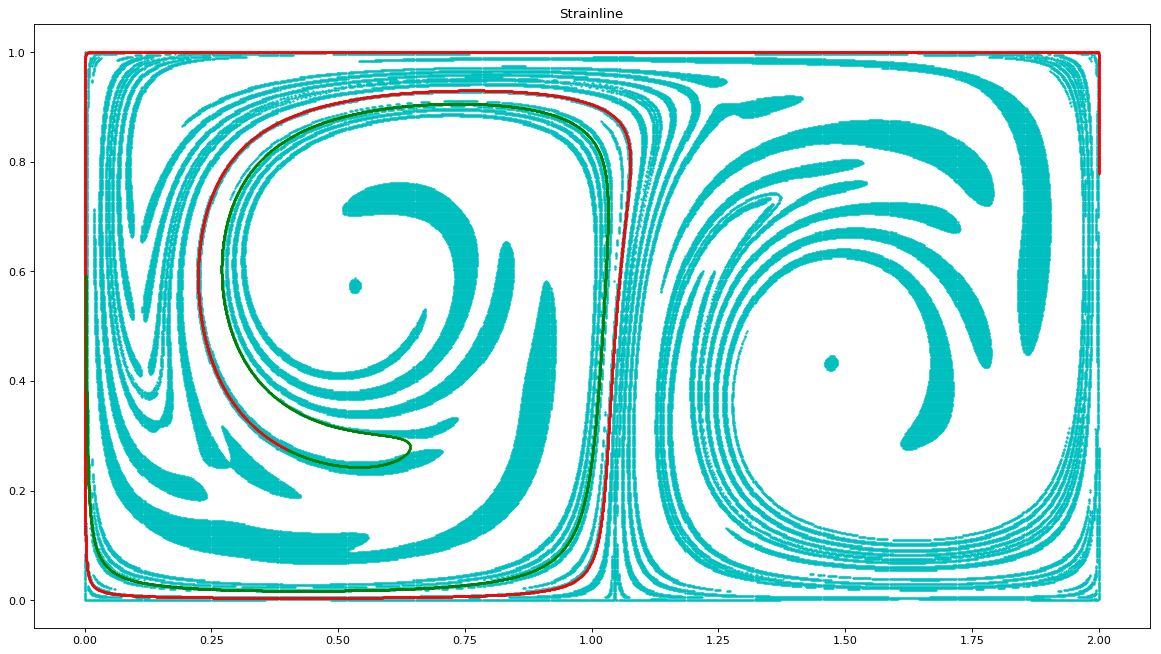

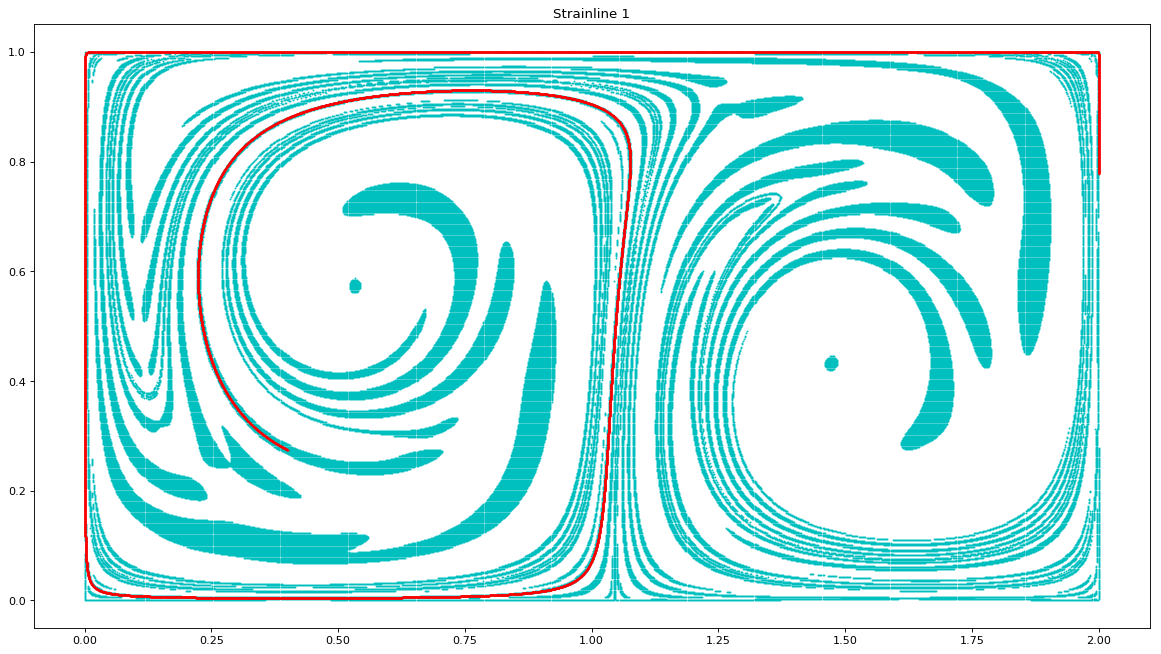

In [115]:
#Strainline 168 is an LCS!
#Strainline 247 is an LCS!
#Strainline 359 is an LCS!
#Strainline 377 is an LCS!
#Strainline 378 is an LCS!
#Strainline 696 is an LCS!

num = 247
domainpoints_y, domainpoints_x = selectg0(domain_points_y,domain_points_x,Ly_index,Lx_index)
strainline_1, l2_avg_1, linelength_1, stopcriterion_1 = iteratestrainline(domainpoints_y[num],domainpoints_x[num],d,tol,lf)
strainline_2, l2_avg_2, linelength_2, stopcriterion_2 = iteratestrainline_reverse(domainpoints_y[num],domainpoints_x[num],d,tol,lf)

stopcriterion = np.append(stopcriterion_1, stopcriterion_2,0)
print(stopcriterion)

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=5, color='c')
plt.scatter(strainline_1[1,:],strainline_1[0,:], marker='.', s=2, color='r')
plt.scatter(strainline_2[1,:],strainline_2[0,:], marker='.', s=2, color='g')
plt.title('Strainline')
#plt.xlim(0.25,0.5)
#plt.ylim(0.3,0.6)

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(domain_points_x,domain_points_y, marker='.', s=2, color='c')
plt.scatter(strainline_1[1,:],strainline_1[0,:], marker='.', s=2, color='r')
plt.title('Strainline 1')

#print(domainpoints_x[num], domainpoints_y[num])
#print(len(strainline_2[0,:]))
#print(np.transpose(strainline_2[::-1,1800:1210]))
#print('-------------------')
#print(np.transpose(strainline_1[::-1,1067:1069]))

#print(xi1x.ev(0.01396038, 1.07313301))
#print(xi1y.ev(0.01396038, 1.07313301))
#print('-------------------------------_')
#print(lmd1.ev(0.01396038, 1.07313301))
#print(lmd2.ev(0.01396038, 1.07313301))
#print('-------------------------------_')
#print(computealpha(lmd1,lmd2,0.01396038, 1.07313301))

#print(xi1x.ev(0.01996038, 1.07813301))
#print(xi1y.ev(0.01996038, 1.07813301))
#print('-------------------------------_')
#print(lmd1.ev(0.01996038, 1.07813301))
#print(lmd2.ev(0.01996038, 1.07813301))
#print('-------------------------------_')
#print(computealpha(lmd1,lmd2,0.01996038, 1.07813301))

#def computealpha(lmd1,lmd2,y,x): #Compute alpha for use in the gradient of the strainline
#    alpha = ((lmd2.ev(y,x) - lmd1.ev(y,x))/(lmd2.ev(y,x) + lmd1.ev(y,x)))**2
#    return alpha

#lambda1_2D, lambda2_2D, lapll_2D, eigvec1_2D, eigvec2_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)


#print(lambda1_2D.shape)


plt.show()

In [14]:
## Plotting the vector fields

# Sampled

disp_freq = 1

eigvec2_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)[4]
eigvec1_2D = convert22D(lambda1, lambda2, eigvec1, eigvec2, lapll)[3]

y0_pos, x0_pos = np.linspace(0,H,Ny), np.linspace(0,L,Nx)
y0_pos, x0_pos = y0_pos[::disp_freq], x0_pos[::disp_freq]
Y, X = np.meshgrid(y0_pos, x0_pos)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(18, 8), dpi=100, facecolor='w', edgecolor='k')

ax3.set_title('Eigenvector 2')
ax3.quiver(X, Y, eigvec2_2D[1,::disp_freq,::disp_freq].T, eigvec2_2D[0,::disp_freq,::disp_freq].T, units='width')

ax1.set_title('Eigenvector 1')
ax1.quiver(X, Y, eigvec1_2D[1,::disp_freq,::disp_freq].T, eigvec1_2D[0,::disp_freq,::disp_freq].T, units='width')

# Interpolated

y0_pos, x0_pos = np.linspace(-deltay/2,H-deltay/2,Ny), np.linspace(-deltax/2,L-deltax/2,Nx)
#y0_pos, x0_pos = np.linspace(deltay/2,H-deltay/2,Ny-1), np.linspace(deltax/2,L-deltax/2,Nx-1)
y0_pos, x0_pos = y0_pos[::disp_freq], x0_pos[::disp_freq]
Y, X = np.meshgrid(y0_pos, x0_pos)

eigvec1_2Dinterp = np.zeros((2,len(x0_pos),len(y0_pos)))
eigvec2_2Dinterp = np.zeros((2,len(x0_pos),len(y0_pos)))

#for j in range(0,len(y0_pos)):
#    for i in range(0,len(x0_pos)):
#        eigvec1_2Dinterp[0,i,j] = xi1y(y0_pos[j],x0_pos[i])
#        eigvec1_2Dinterp[1,i,j] = xi1x(y0_pos[j],x0_pos[i])
#        eigvec2_2Dinterp[0,i,j] = xi2y(y0_pos[j],x0_pos[i])
#        eigvec2_2Dinterp[1,i,j] = xi2x(y0_pos[j],x0_pos[i])
        
for j in range(0,len(y0_pos)):
    eigvec1_2Dinterp[0,:,j] = xi1y(y0_pos[j],x0_pos)
    eigvec1_2Dinterp[1,:,j] = xi1x(y0_pos[j],x0_pos)
    eigvec2_2Dinterp[0,:,j] = xi2y(y0_pos[j],x0_pos)
    eigvec2_2Dinterp[1,:,j] = xi2x(y0_pos[j],x0_pos)

ax4.set_title('Interpolated eigenvector 2')
ax4.quiver(X, Y, eigvec2_2Dinterp[1], eigvec2_2Dinterp[0], units='width')

ax2.set_title('Interpolated eigenvector 1')
ax2.quiver(X, Y, eigvec1_2Dinterp[1], eigvec1_2Dinterp[0], units='width')

plt.savefig('/home/simonno/Dropbox/Project_Veii/Veii/Figures/Xifields_2.png', dpi=300)

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.quiver(X, Y, eigvec2_2Dinterp[1], eigvec2_2Dinterp[0], units='width')

plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

In [41]:
xi1y.ev(0.54,1.62)

#print(xi2y(0,0))
#print(xi2x(0,0))

array(-0.8533559321718771)

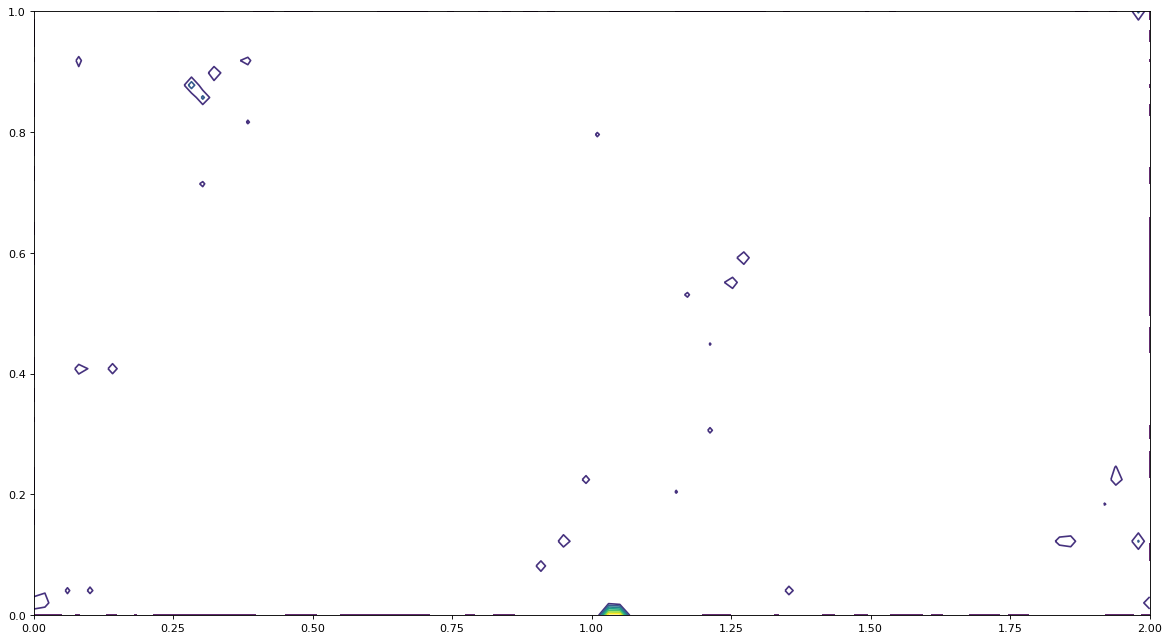

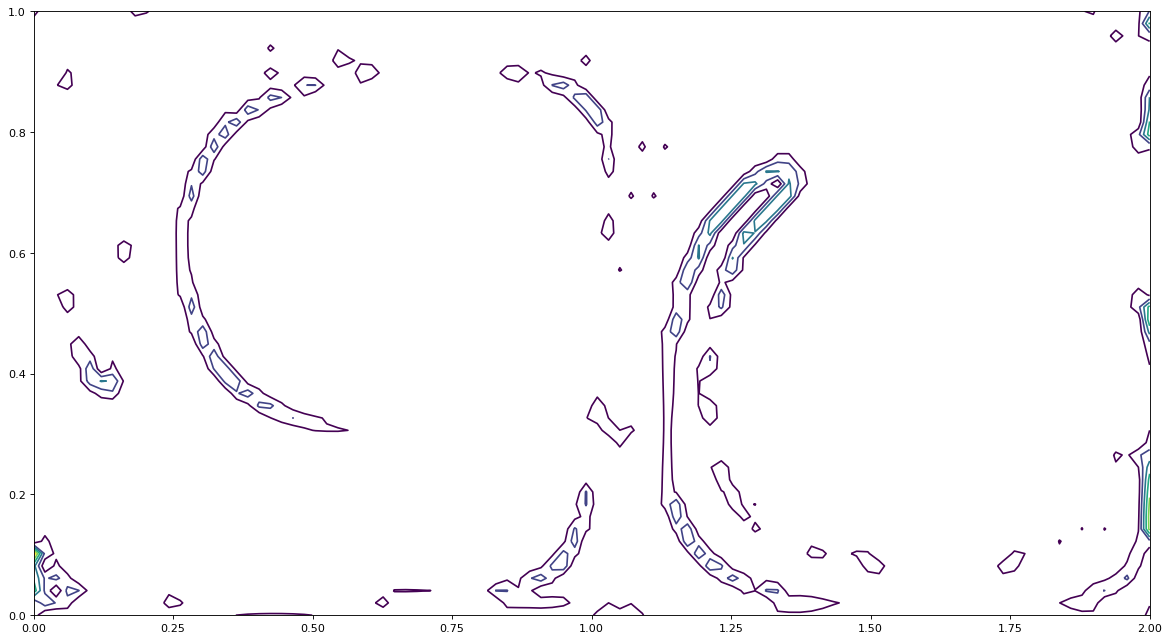

In [75]:
y0_pos, x0_pos = np.linspace(0,H,Ny), np.linspace(0,L,Nx)
Y, X = np.meshgrid(y0_pos, x0_pos)

fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.contour(X,Y,lmd1.ev(Y,X))
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.contour(X,Y,lmd2.ev(Y,X))
plt.show()

In [ ]:
# Suggestions:



# * Check whether changing maxiter actually makes a difference (by comparing images side to side)


# * What is up with the numbering of the strainlines?

# * Check whether max_intsec_guess should be made faster
# * Look into making selection of LCS faster
# * Check whether interpolations at top boundary are weird...
# * Test RK2 iterator
# * Test Tor's iterator

# * Try different interpolation schemes
# * Change how I add to linelength
# * May want to compute average after combining the two directions

# * Why do I get random jumps?
# * Convert stopcriteria to a more manageable form and use to find what stops LCS iteration
# * Check what is up with the splitting up of strainlines -> The numbers are not regular. Irregular # points in g0
# * Test RK4 without special drds_last -> Works much better
# * Paralellize computation of eigenvectors and eigenvalues
# * It looks like the strainlines follow the ridges well, but occasionally they stray off course
# * Do second order differentiation on the edges
# * Make sure that interpolated eigenvectors are awlays normalized before they are used
# * Try to parallelize the LCS selection
# * Try to run with smaller step and more particles, but smaller tolerance for being outside AB _> Not promising
# * May want to calculate drds for intermediate stages in the RK4 solver
# * Try smaller time-step in RK4 particle transport and see if AB field looks better -> It didnt
# * Extend the domain as described by Haller
# * Try using the eigenvector 1 field as input
# * Focus on the first step -> I believe the results are good enough to warrant correct input -> Looks to be OK
# * Decrease amount of initialization by only doing it once
# * Comparing explicit Euler with RK4
# * Fix the issue with only considering neighbors around the first intersection with a line
# * Since all particles are now going to become strainlines, we know their number. Less appending?
# * Change the outer boundary at which the iteration process stops

# * Test changing the paranthesis regarding the laplacian in condition B (or A?) -> Arne did so
# * Paralellize the computation of regular and auxiliary strain tensors and computation of eigenvalues/eigenvectors


Notes:

- Why don't I have AB on the entire top line
- Why do I get these weird jumps when using RK4?
- Higher order spline interpolation for not necessarily continuous variables such as eigenvalues and eigenvectors makes for trouble
- EV call worth it or not?


- Notice the artifact in the FTLE field (blob growing out of the spiral)


In [94]:
print(stopcriteria[0][0])
stopped = stopcriteria[0]
for i in range(1,Ncores):
    stopped = np.append(stopped,stopcriteria[i],0)
print(stopped.shape)
    
    

[0, 0, 1, 1, 0, 0]
(1365, 6)


In [26]:
print(not np.mod(100,100))

True
